In [579]:
import geopy
from geopy.extra.rate_limiter import RateLimiter


import pandas as pd
import numpy as np
import geopandas as gpd

from matplotlib import pyplot as plt
import shapely

%matplotlib inline

import contextily as ctx
import requests

from tqdm.auto import tqdm, trange
tqdm.pandas()

from geopy_nominatim_wrapper import NominatimWrapper

import seaborn as sbn

from credentials import here_api_key, bing_api_key, mapbox_api_key, tomtom_api_key

import plotly.express as px

fig_path = "output/geocoding/figs"

from fpdf import FPDF 

In [580]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

In [581]:
def add_basemap(ax, zoom='auto'):
    """
    Add a basemap on a plot. Tries first default (Stamen) basemap. If errors, tries OpenStreetMap.Mapnik
    
    Parameters
    ----------
    ax: matplotlib axes
    
    Returns
    -------
        None
    """

    try: 
        ctx.add_basemap(ax, zoom=zoom)
    except requests.HTTPError:
        print("Default basemap doesn't work...")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)

In [582]:
def pdf_add_image(pdf, filename, orientation="L", width=290):
    pdf.add_page(orientation)
    pdf.image(filename, 0, 0, width)


# Prepare geocoders

In [583]:
def get_precision(record):
    
    precision_field= {
        "nominatim": "class",
        "nominatim_local": "class",
        "nominatim_wrapper": "place_rank",
        "nominatim_wrapper2": "place_rank",
        "here": "MatchLevel",
        "photon_local": ("properties", "type"),
        "bing": "entityType",
        "mapbox": ("properties", "accuracy"),
        "tomtom": "type"
    }
    
    label_mapping = {
        "nominatim": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
                      
                      
        "nominatim_local": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
        
        "nominatim_wrapper": {30:"building", 
                              27: "street",
                              26: "street",
                              25: "city",
                              22: "city",
                              21: "city",
                              19: "city",
                              16: "city",
                              14: "city"},
        "nominatim_wrapper2": {30:"building", 
                      27: "street",
                      26: "street",
                      25: "city",
                      22: "city",
                      21: "city",
                      19: "city",
                      16: "city",
                              14: "city"},

        "here": {"houseNumber": "building",
                "street": "street",
                "city": "city",
                "postalCode": "city"},
        "photon_local": {
            "house": "building",
            "locality": "city",
            "street": "street"},
        "bing": { "Address": "building",
                  "RoadBlock": "street",
                 "PopulatedPlace": "city",
                 "Postcode1": "city",
                 "CountryRegion": "country"
                },
        "mapbox": {"rooftop": "building",
                   "point": "building",
                   "interpolated": "building",
                  "street": "street"},
        
        "tomtom": {"Point Address": "building",
                  "Street": "street",
                  "Address Range": "street",
                  "Cross Street": "street",
                  "Geography": "city"}
        
    }
    
    try: 
        f = precision_field[record.geocoder]
        mapper = label_mapping[record.geocoder]
        if isinstance(f, str):
            raw_label = record.location.raw[f]
        else: 
            raw_label =  record.location.raw[f[0]][f[1]]
        return mapper[raw_label] if raw_label in mapper else f"[UNKNOWN - {raw_label}]"
    except KeyError: 
        return "[UNKNOWN]"
    
    

In [584]:
geocoders = {}

In [585]:
from geopy.geocoders import Nominatim
geocoders['nominatim_local'] = Nominatim(user_agent="smalsresearch", domain="172.17.0.2:8080", scheme="http", timeout=1000)
geocoders['nominatim'] = Nominatim(user_agent="smalsresearch")


In [586]:
geocoders['nominatim_wrapper'] = NominatimWrapper(user_agent="smalsresearch", scheme="http", timeout=1000)

In [587]:
#geocoders['nominatim_wrapper'].geocode("Chaussée de qryq")

In [588]:
# geocoded_data.groupby(["geocoder", "precision"]).count()

In [589]:
from geopy.geocoders import Here
geocoders['here'] = Here(apikey=here_api_key)

In [590]:
from geopy.geocoders import Bing
geocoders['bing'] = Bing(api_key=bing_api_key)

In [591]:
from geopy.geocoders import Photon
geocoders['photon'] = Photon(domain="photon.komoot.io")

geocoders['photon_local'] = Photon(domain="127.0.0.1:2322", scheme="http")

In [592]:
from geopy.geocoders import MapBox
geocoders['mapbox'] = MapBox(api_key=mapbox_api_key)

In [593]:
from geopy.geocoders import TomTom
geocoders['tomtom'] =TomTom(api_key=tomtom_api_key)

In [594]:
# geocoders['tomtom'].geocode("Chaussée de Tervuren 59, 1160 Auderghem").raw

In [595]:
# geocoders['here'].geocode("Chaussée de Tervueren").raw


In [596]:
pdf = FPDF(orientation='L')
# pdf.add_page()/


# Load data


In [597]:
sample_size = 1000
dataset = f"kbo_{sample_size}"
data = pd.read_csv("../NominatimWrapper/address.csv.gz", 
                   usecols=["StreetFR", "HouseNumber", "Zipcode", "MunicipalityFR", "CountryFR"], 
                   dtype=str)
data = data[data.CountryFR.isnull()]
data = data.fillna("")


# Takes slightly more, to be able to drop duplicates afterwards
data = data.sample(int(sample_size*1.5), random_state=5)

data["address"] = data.StreetFR+", "+ \
            data.HouseNumber+", "+ \
            data.Zipcode.astype(str).str.replace(".0", "", regex=False)+ " "+data.MunicipalityFR + \
            ", Belgique"
data = data[["address"]]
data = data.drop_duplicates()

data = data.sample(sample_size, random_state=5)

data

address
2762939          Kriekenlaan, 22, 2240 Zandhoven, Belgique
2253494        Cardijnlaan(D), *, 8600 Diksmuide, Belgique
1764140          Poststraat, 19, 9860 Oosterzele, Belgique
87070    Sylvain Dupuisstraat, 26, 8300 Knokke-Heist, B...
2261339     Oude Baan(M), 338, 3630 Maasmechelen, Belgique
...                                                    ...
2720764  Rue du Wainage(VEL), 62, 5060 Sambreville, Bel...
386196   Chaussée de Tournai(R-C), 4, 7520 Tournai, Bel...
1474962  Rue Louis Caty(B), 32, 7331 Saint-Ghislain, Be...
2424889  Drève des Bouleaux, 5, 7090 Braine-le-Comte, B...
2751621                  Rue Rogier, 1, 4900 Spa, Belgique

[1000 rows x 1 columns]

In [598]:
data

address
2762939          Kriekenlaan, 22, 2240 Zandhoven, Belgique
2253494        Cardijnlaan(D), *, 8600 Diksmuide, Belgique
1764140          Poststraat, 19, 9860 Oosterzele, Belgique
87070    Sylvain Dupuisstraat, 26, 8300 Knokke-Heist, B...
2261339     Oude Baan(M), 338, 3630 Maasmechelen, Belgique
...                                                    ...
2720764  Rue du Wainage(VEL), 62, 5060 Sambreville, Bel...
386196   Chaussée de Tournai(R-C), 4, 7520 Tournai, Bel...
1474962  Rue Louis Caty(B), 32, 7331 Saint-Ghislain, Be...
2424889  Drève des Bouleaux, 5, 7090 Braine-le-Comte, B...
2751621                  Rue Rogier, 1, 4900 Spa, Belgique

[1000 rows x 1 columns]

In [599]:
import glob
sample_size=1000
dataset = f"resto_{sample_size}"
data = pd.concat([pd.read_csv(f) for f in glob.glob("data/geocoding/resto_*.csv")]).drop("Unnamed: 0", axis=1)
data = data[data.street.notnull()]
data["address"] = data.street+", "+ \
            data.housenumber+", "+ \
            data.postcode.astype(str).str.replace(".0", "", regex=False)+ " "+data.city + \
            ", Belgique"

data = data[["address"]].drop_duplicates().reset_index(drop=True)

if sample_size: 
    data = data.sample(sample_size,random_state=5)
data

address
2551       Chaussée de Namur, 198, 5310 LEUZE, Belgique
2366          Rue de la Halle, 11, 5000 NAMUR, Belgique
3122  Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...
1823          rue du Centre, 200, 4950 WAIMES, Belgique
1333     Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique
...                                                 ...
3212         Rue Americaine, 90, 1050 IXELLES, Belgique
1029          Kloosterstraat, 60, 2180 EKEREN, Belgique
1006                    Markt, 13, 2490 BALEN, Belgique
1276     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique
3824        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique

[1000 rows x 1 columns]

# Geocode

In [600]:
geocoded_data_r = []#gpd.GeoDataFrame()
#coders=["nominatim_wrapper","nominatim_wrapper2",  "photon_local", "here", "bing", "mapbox"] # "nominatim_local"
coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox", "tomtom"] #  ,"nominatim_local"

delay={"mapbox":0.5, "nominatim_wrapper":0.01,  "nominatim_local":0.01}
from_file = ["nominatim_wrapper","nominatim_local", "here", "bing", "mapbox", "tomtom"]#"nominatim_local", "photon_local", "here", "bing", "mapbox"]
for coder in coders: #geocoders:
    print(coder)
    
    if coder in from_file:
        print("Load from local file...")
        g_data = pd.read_pickle(f"output/geocoding/geocoded_{dataset}_{coder}.pkl")
    else: 
        geocode = RateLimiter(geocoders[coder].geocode, min_delay_seconds=delay[coder] if coder in delay else 0.2)

        g_data = data.assign(location=data['address'].progress_apply(geocode)).assign(geocoder=coder)
        g_data.to_pickle(f"output/geocoding/geocoded_{dataset}_{coder}.pkl")
    
    geocoded_data_r.append(g_data)
    display(g_data)
    

nominatim_wrapper
Load from local file...


address  \
2551       Chaussée de Namur, 198, 5310 LEUZE, Belgique   
2366          Rue de la Halle, 11, 5000 NAMUR, Belgique   
3122  Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...   
1823          rue du Centre, 200, 4950 WAIMES, Belgique   
1333     Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique   
...                                                 ...   
3212         Rue Americaine, 90, 1050 IXELLES, Belgique   
1029          Kloosterstraat, 60, 2180 EKEREN, Belgique   
1006                    Markt, 13, 2490 BALEN, Belgique   
1276     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique   
3824        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique   

                                               location           geocoder  
2551  (198, Chaussée de Namur, Leuze, Éghezée, Namur...  nominatim_wrapper  
2366  (Rue de la Halle, Namur, Wallonie, 5000, Belgi...  nominatim_wrapper  
3122  (38, Avenue Jacques Sermon - Jacques Sermonlaa...  nominatim_wrapper  
1823  (Rue du Centre, Waimes, Verviers, Liège, Wallo...  nominatim_wrapper  
1333  (Tennisclub Lybo, 9, Kleine Waterstraat, Houtv...  nominatim_wrapper  
...                                                 ...                ...  
3212  (Rue Américaine - Amerikaanse straat, Ixelles ...  nominatim_wrapper  
1029  (Gino, 60, Kloosterstraat, Schoonbroek, Ekeren...  nominatim_wrapper  
1006  (Markt, Balen, Turnhout, Antwerpen, Vlaanderen...  nominatim_wrapper  
1276  (Den Abattoir, 65, Lange Lobroekstraat, Stuive...  nominatim_wrapper  
3824  (Horia, 7, Borgval - Borgwal, Quartier Saint-G...  nominatim_wrapper  

[1000 rows x 3 columns]

nominatim_local
Load from local file...


address  \
2551       Chaussée de Namur, 198, 5310 LEUZE, Belgique   
2366          Rue de la Halle, 11, 5000 NAMUR, Belgique   
3122  Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...   
1823          rue du Centre, 200, 4950 WAIMES, Belgique   
1333     Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique   
...                                                 ...   
3212         Rue Americaine, 90, 1050 IXELLES, Belgique   
1029          Kloosterstraat, 60, 2180 EKEREN, Belgique   
1006                    Markt, 13, 2490 BALEN, Belgique   
1276     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique   
3824        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique   

                                               location         geocoder  
2551  (198, Chaussée de Namur, Leuze, Éghezée, Namur...  nominatim_local  
2366  (Rue de la Halle, Namur, Wallonie, 5000, Belgi...  nominatim_local  
3122  (38, Avenue Jacques Sermon - Jacques Sermonlaa...  nominatim_local  
1823  (Rue du Centre, Waimes, Verviers, Liège, Wallo...  nominatim_local  
1333  (Tennisclub Lybo, 9, Kleine Waterstraat, Houtv...  nominatim_local  
...                                                 ...              ...  
3212  (Rue Américaine - Amerikaanse straat, Ixelles ...  nominatim_local  
1029  (Gino, 60, Kloosterstraat, Schoonbroek, Ekeren...  nominatim_local  
1006  (Markt, Balen, Turnhout, Antwerpen, Vlaanderen...  nominatim_local  
1276  (Den Abattoir, 65, Lange Lobroekstraat, Stuive...  nominatim_local  
3824  (Horia, 7, Borgval - Borgwal, Quartier Saint-G...  nominatim_local  

[1000 rows x 3 columns]

here
Load from local file...


address  \
2551       Chaussée de Namur, 198, 5310 LEUZE, Belgique   
2366          Rue de la Halle, 11, 5000 NAMUR, Belgique   
3122  Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...   
1823          rue du Centre, 200, 4950 WAIMES, Belgique   
1333     Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique   
...                                                 ...   
3212         Rue Americaine, 90, 1050 IXELLES, Belgique   
1029          Kloosterstraat, 60, 2180 EKEREN, Belgique   
1006                    Markt, 13, 2490 BALEN, Belgique   
1276     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique   
3824        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique   

                                               location geocoder  
2551  (Chaussée de Namur 198, 5310 Eghezée, Belgique...     here  
2366  (Rue de la Halle 11, 5000 Namur, Belgique, Nam...     here  
3122  (Avenue Jacques Sermon 38, 1083 Ganshoren, Bel...     here  
1823  (Rue du Centre, 4950 Waimes, Belgique, Waimes,...     here  
1333  (Kleine Waterstraat 9, 2235 Hulshout, België, ...     here  
...                                                 ...      ...  
3212  (Rue Américaine 90, 1050 Ixelles, Belgique, Ix...     here  
1029  (Kloosterstraat 60, 2180 Antwerpen, België, An...     here  
1006  (Markt 13, 2490 Balen, België, Balen, Vlaander...     here  
1276  (Lange Lobroekstraat 65, 2060 Antwerpen, Belgi...     here  
3824  (Borgval 7, 1000 Bruxelles, Belgique, Bruxelle...     here  

[1000 rows x 3 columns]

bing
Load from local file...


address  \
2551       Chaussée de Namur, 198, 5310 LEUZE, Belgique   
2366          Rue de la Halle, 11, 5000 NAMUR, Belgique   
3122  Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...   
1823          rue du Centre, 200, 4950 WAIMES, Belgique   
1333     Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique   
...                                                 ...   
3212         Rue Americaine, 90, 1050 IXELLES, Belgique   
1029          Kloosterstraat, 60, 2180 EKEREN, Belgique   
1006                    Markt, 13, 2490 BALEN, Belgique   
1276     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique   
3824        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique   

                                               location geocoder  
2551  (Chaussée de Namur 198, Eghezée, Walloon Regio...     bing  
2366  (Rue de la Halle 11, Namur, Walloon Region 500...     bing  
3122  (Avenue Jacques Sermon 38, Brussels, Brussels-...     bing  
1823  (Rue du Centre, Waimes, Walloon Region 4950, B...     bing  
1333  (Kleine Waterstraat 9, Hulshout, Flemish Regio...     bing  
...                                                 ...      ...  
3212  (Rue Américaine 90, Brussels, Brussels-Capital...     bing  
1029  (Kloosterstraat 60, Antwerp, Flemish Region 21...     bing  
1006  (Markt 13, Balen, Flemish Region 2490, Belgium...     bing  
1276  (Lange Lobroekstraat 65, Antwerp, Flemish Regi...     bing  
3824  (Borgval 7, Brussels, Brussels-Capital Region ...     bing  

[1000 rows x 3 columns]

mapbox
Load from local file...


address  \
2551       Chaussée de Namur, 198, 5310 LEUZE, Belgique   
2366          Rue de la Halle, 11, 5000 NAMUR, Belgique   
3122  Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...   
1823          rue du Centre, 200, 4950 WAIMES, Belgique   
1333     Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique   
...                                                 ...   
3212         Rue Americaine, 90, 1050 IXELLES, Belgique   
1029          Kloosterstraat, 60, 2180 EKEREN, Belgique   
1006                    Markt, 13, 2490 BALEN, Belgique   
1276     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique   
3824        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique   

                                               location geocoder  
2551  (Chaussée De Namur 198, Eghezée, 5310 Namur, B...   mapbox  
2366  (Rue De La Halle 11, Namur, 5000 Namur, Belgiu...   mapbox  
3122  (Avenue Jacques Sermon - Jacques Sermonlaan 38...   mapbox  
1823  (Rue Du Centre, Waimes, 4950 Liège, Belgium, (...   mapbox  
1333  (Kleine Waterstraat 9, Hulshout, 2235 Antwerp,...   mapbox  
...                                                 ...      ...  
3212  (Rue Américaine - Amerikaanse Straat 90, Ixell...   mapbox  
1029  (Kloosterstraat 60, Antwerpen, 2180 Antwerp, B...   mapbox  
1006  (Markt 13, Balen, 2490 Antwerp, Belgium, (51.1...   mapbox  
1276  (Lange Lobroekstraat 65, Antwerpen, 2060 Antwe...   mapbox  
3824  (Borgval - Borgwal 7, Brussels, 1000 Brussels-...   mapbox  

[1000 rows x 3 columns]

tomtom
Load from local file...


address  \
2551       Chaussée de Namur, 198, 5310 LEUZE, Belgique   
2366          Rue de la Halle, 11, 5000 NAMUR, Belgique   
3122  Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...   
1823          rue du Centre, 200, 4950 WAIMES, Belgique   
1333     Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique   
...                                                 ...   
3212         Rue Americaine, 90, 1050 IXELLES, Belgique   
1029          Kloosterstraat, 60, 2180 EKEREN, Belgique   
1006                    Markt, 13, 2490 BALEN, Belgique   
1276     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique   
3824        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique   

                                               location geocoder  
2551  (Chaussée de Namur 198, 5310 Eghezée, (50.5556...   tomtom  
2366  (Rue de la Halle 11, 5000 Namur, (50.46273, 4....   tomtom  
3122  (Avenue Jacques Sermon 38, 1083 Bruxelles, (50...   tomtom  
1823  (Rue du Centre, 4950 Waimes, (50.41504, 6.11123))   tomtom  
1333  (Kleine Waterstraat 9, 2235 Hulshout, (51.0399...   tomtom  
...                                                 ...      ...  
3212  (Rue Américaine 90, 1050 Bruxelles, (50.82335,...   tomtom  
1029  (Kloosterstraat 60, 2180 Antwerpen, (51.28145,...   tomtom  
1006        (Markt 13, 2490 Balen, (51.17048, 5.16843))   tomtom  
1276  (Lange Lobroekstraat 65, 2060 Antwerpen, (51.2...   tomtom  
3824    (Borgval 7, 1000 Bruxelles, (50.84764, 4.3484))   tomtom  

[1000 rows x 3 columns]

In [601]:
# g_data = pd.read_pickle(f"output/geocoded_nominatim_wrapper2.pkl")
# g_data["geocoder"] = "nominatim_wrapper2"
# g_data.to_pickle(f"output/geocoded_nominatim_wrapper2.pkl")

In [602]:
geocoded_data = pd.concat(geocoded_data_r).reset_index(drop=True)
geocoded_data = geocoded_data[geocoded_data.location.notnull()]
geocoded_data    
    

address  \
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique   
2     Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...   
3             rue du Centre, 200, 4950 WAIMES, Belgique   
4        Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique   
...                                                 ...   
5995         Rue Americaine, 90, 1050 IXELLES, Belgique   
5996          Kloosterstraat, 60, 2180 EKEREN, Belgique   
5997                    Markt, 13, 2490 BALEN, Belgique   
5998     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique   
5999        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique   

                                               location           geocoder  
0     (198, Chaussée de Namur, Leuze, Éghezée, Namur...  nominatim_wrapper  
1     (Rue de la Halle, Namur, Wallonie, 5000, Belgi...  nominatim_wrapper  
2     (38, Avenue Jacques Sermon - Jacques Sermonlaa...  nominatim_wrapper  
3     (Rue du Centre, Waimes, Verviers, Liège, Wallo...  nominatim_wrapper  
4     (Tennisclub Lybo, 9, Kleine Waterstraat, Houtv...  nominatim_wrapper  
...                                                 ...                ...  
5995  (Rue Américaine 90, 1050 Bruxelles, (50.82335,...             tomtom  
5996  (Kloosterstraat 60, 2180 Antwerpen, (51.28145,...             tomtom  
5997        (Markt 13, 2490 Balen, (51.17048, 5.16843))             tomtom  
5998  (Lange Lobroekstraat 65, 2060 Antwerpen, (51.2...             tomtom  
5999    (Borgval 7, 1000 Bruxelles, (50.84764, 4.3484))             tomtom  

[5827 rows x 3 columns]

In [603]:
geocoded_data[geocoded_data.address.str.contains("Montén")]

Empty DataFrame
Columns: [address, location, geocoder]
Index: []

## Extract precision

In [604]:
geocoded_data["precision"] = geocoded_data.apply(get_precision, axis=1)

In [605]:
geocoded_data[geocoded_data.precision.str.contains("UNK")][["geocoder" , "precision"]].drop_duplicates()

geocoder             precision
1004  nominatim_local      [UNKNOWN - club]
1015  nominatim_local   [UNKNOWN - tourism]
1161  nominatim_local     [UNKNOWN - craft]
1294  nominatim_local    [UNKNOWN - office]
1298  nominatim_local  [UNKNOWN - historic]
1509  nominatim_local   [UNKNOWN - railway]
1707  nominatim_local   [UNKNOWN - leisure]
1748  nominatim_local  [UNKNOWN - man_made]
2892             here  [UNKNOWN - district]
4037           mapbox             [UNKNOWN]

In [606]:
geocoded_data["precision"] = geocoded_data.precision.replace("^\[UNKNOWN.*\]", "[UNKNOWN]", regex=True)

In [607]:
# geocoded_data.loc[599].location.raw#["entityType"]

In [608]:
# geocoders["mapbox"].geocode("2627 Schelle").raw

In [609]:
lat = geocoded_data["location"].apply(lambda loc: loc.point.latitude if loc else None)
lng =  geocoded_data["location"].apply(lambda loc: loc.point.longitude if loc else None)
geocoded_data["point"] = np.where(lat.notnull(), gpd.points_from_xy(lng, lat), pd.NA)

In [610]:
geocoded_data = gpd.GeoDataFrame(geocoded_data).set_geometry("point").set_crs(osm_crs).to_crs(crs)
geocoded_data

address  \
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique   
2     Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...   
3             rue du Centre, 200, 4950 WAIMES, Belgique   
4        Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique   
...                                                 ...   
5995         Rue Americaine, 90, 1050 IXELLES, Belgique   
5996          Kloosterstraat, 60, 2180 EKEREN, Belgique   
5997                    Markt, 13, 2490 BALEN, Belgique   
5998     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique   
5999        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique   

                                               location           geocoder  \
0     (198, Chaussée de Namur, Leuze, Éghezée, Namur...  nominatim_wrapper   
1     (Rue de la Halle, Namur, Wallonie, 5000, Belgi...  nominatim_wrapper   
2     (38, Avenue Jacques Sermon - Jacques Sermonlaa...  nominatim_wrapper   
3     (Rue du Centre, Waimes, Verviers, Liège, Wallo...  nominatim_wrapper   
4     (Tennisclub Lybo, 9, Kleine Waterstraat, Houtv...  nominatim_wrapper   
...                                                 ...                ...   
5995  (Rue Américaine 90, 1050 Bruxelles, (50.82335,...             tomtom   
5996  (Kloosterstraat 60, 2180 Antwerpen, (51.28145,...             tomtom   
5997        (Markt 13, 2490 Balen, (51.17048, 5.16843))             tomtom   
5998  (Lange Lobroekstraat 65, 2060 Antwerpen, (51.2...             tomtom   
5999    (Borgval 7, 1000 Bruxelles, (50.84764, 4.3484))             tomtom   

     precision                           point  
0     building  POINT (546289.414 6543063.152)  
1       street  POINT (541625.695 6526810.311)  
2     building  POINT (481018.223 6598096.944)  
3       street  POINT (680379.741 6518655.149)  
4     building  POINT (535332.081 6628370.736)  
...        ...                             ...  
5995  building  POINT (485258.358 6590105.668)  
5996  building  POINT (491767.209 6671230.785)  
5997  building  POINT (575346.996 6651505.244)  
5998  building  POINT (493394.700 6661940.684)  
5999  building  POINT (484061.674 6594387.125)  

[5827 rows x 5 columns]

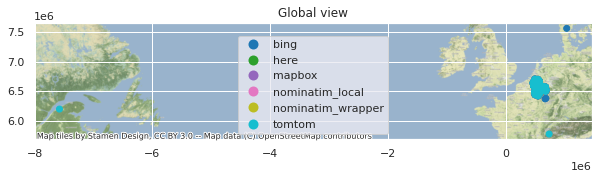

In [611]:
ax=geocoded_data.plot("geocoder", legend=True, figsize=(10,15))
plt.title("Global view")
add_basemap(ax)
img_name=f"{fig_path}/global_{dataset}.png"
plt.savefig(img_name,  bbox_inches='tight')
pdf_add_image(pdf, img_name)
# pdf.add_page()
# pdf.image(f"{fig_path}/global_{dataset}.png", 0, 0, 290)


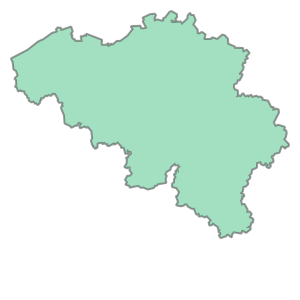

In [612]:
belgium_boundaries = gpd.read_file("data/boundaries.geojson")
belgium_boundaries = belgium_boundaries[belgium_boundaries.name == "BEL"].geometry.iloc[0].simplify(1000).buffer(1000)
belgium_boundaries

In [613]:
geocoded_data["is_in_belgium"]= geocoded_data.geometry.within(belgium_boundaries)
geocoded_data["is_in_belgium"].value_counts()

True     5816
False      11
Name: is_in_belgium, dtype: int64

In [614]:
geocoded_data[~geocoded_data.is_in_belgium]

address  \
826       Molenstraat, 42, 2387 BAARLE-HERTOG, Belgique   
1826      Molenstraat, 42, 2387 BAARLE-HERTOG, Belgique   
2826      Molenstraat, 42, 2387 BAARLE-HERTOG, Belgique   
3382   Rue de Danemark, 29, 1060 SAINT-GILLES, Belgique   
3527      Rue du Luxembourg, 35, 1050 IXELLES, Belgique   
3726  Rue du Luxembourg, 68, 1000 BRUXELLES CENTRE, ...   
3826      Molenstraat, 42, 2387 BAARLE-HERTOG, Belgique   
4826      Molenstraat, 42, 2387 BAARLE-HERTOG, Belgique   
5178     Avenue de l'Armé, 32, 1040 ETTERBEEK, Belgique   
5348  Boulevard Général Jacques, 212, 1050 IXELLES, ...   
5826      Molenstraat, 42, 2387 BAARLE-HERTOG, Belgique   

                                               location           geocoder  \
826   (42, Molenstraat, Baarle-Hertog, Turnhout, Ant...  nominatim_wrapper   
1826  (42, Molenstraat, Baarle-Hertog, Turnhout, Ant...    nominatim_local   
2826  (Molenstraat 42, 2387 Baarle-Hertog, België, B...               here   
3382  (Denmark, (56.03480911254883, 9.319060325622559))               bing   
3527  (35 Rue du Mur, Luxembourg, Luxembourg L-2174,...               bing   
3726  (68 Rue du Centre, Reckange-sur-Mess, Esch-sur...               bing   
3826  (Molenstraat 42, Baarle-Hertog, Flemish Region...               bing   
4826  (Molenstraat 42, Baarle-Hertog, 2387 Antwerp, ...             mapbox   
5178  (32 Avenue de l'Orme, Sainte-Angèle-de-Mérici ...             tomtom   
5348  (212 Rue du Général Jacques de Montfort, 74700...             tomtom   
5826  (Molenstraat 42, 2387 Baarle-Hertog, (51.44067...             tomtom   

     precision                             point  is_in_belgium  
826   building    POINT (549029.584 6699619.062)          False  
1826  building    POINT (549029.584 6699619.062)          False  
2826  building    POINT (549012.144 6699616.455)          False  
3382   country   POINT (1037393.050 7565348.289)          False  
3527  building    POINT (683866.801 6377333.575)          False  
3726  building    POINT (669988.600 6367662.287)          False  
3826  building    POINT (549013.257 6699616.455)          False  
4826  building    POINT (549011.810 6699617.169)          False  
5178  building  POINT (-7578856.912 6194421.274)          False  
5348    street    POINT (738333.202 5770955.493)          False  
5826  building    POINT (549013.257 6699616.455)          False

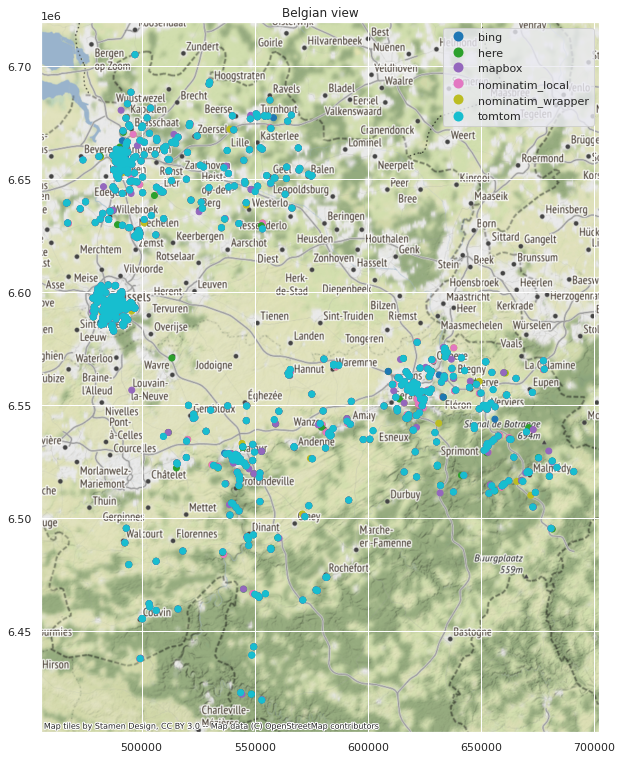

In [615]:
ax=geocoded_data[geocoded_data.is_in_belgium].plot("geocoder", legend=True, figsize=(10,15))
plt.title("Belgian view")
add_basemap(ax)
img_name=f"{fig_path}/belgium_{dataset}.png"
plt.savefig(img_name,  bbox_inches='tight')
pdf_add_image(pdf, img_name, width=240)


## Compute (distance to) median

In [616]:
def get_median_point(bloc):
    bloc = gpd.GeoSeries(bloc.dropna())
    x = np.median(bloc.x)
    y = np.median(bloc.y)
    return shapely.geometry.Point(x, y)
 

In [617]:
median_geocoders = ["here", "bing", "mapbox", "tomtom", "nominatim_wrapper"] # Median based on those geocoders
median_points = geocoded_data[geocoded_data.geocoder.isin(median_geocoders)&( geocoded_data.precision=="building") ].groupby("address").point.apply(get_median_point).rename("median_point").reset_index()
median_points = median_points.set_geometry("median_point").set_crs(geocoded_data.crs)
median_points

address  \
0       Aachener Strasse, 140, 4731 EYNATTEN, Belgique   
1        Aarschotsesteenweg, 6, 2230 HERSELT, Belgique   
2    Adolphe Demeurlaan, 41, 1060 SAINT-GILLES, Bel...   
3    Albert Meunierstraat, 110, 1160 AUDERGHEM, Bel...   
4       Amerikaansestraat, 119, 1050 IXELLES, Belgique   
..                                                 ...   
977  rue des bouchers, 23, 1000 BRUXELLES CENTRE, B...   
978          rue du Collège, 1, 5310 EGHEZEE, Belgique   
979           rue du Trône, 65, 1050 IXELLES, Belgique   
980      rue du Vieux Frêne, 3, 4100 SERAING, Belgique   
981           rue francart, 11, 1050 IXELLES, Belgique   

                       median_point  
0    POINT (677694.136 6569556.084)  
1    POINT (542981.188 6630252.704)  
2    POINT (483663.150 6590470.448)  
3    POINT (493888.958 6587691.831)  
4    POINT (485362.999 6590003.462)  
..                              ...  
977  POINT (484701.761 6594438.255)  
978  POINT (546536.287 6549729.905)  
979  POINT (486280.271 6592715.496)  
980  POINT (618040.247 6545050.950)  
981  POINT (485763.749 6592380.961)  

[982 rows x 2 columns]

In [618]:
geocoded_data = geocoded_data.merge(median_points, how="left")#.dropna()
geocoded_data

address  \
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique   
2     Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...   
3             rue du Centre, 200, 4950 WAIMES, Belgique   
4        Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique   
...                                                 ...   
5822         Rue Americaine, 90, 1050 IXELLES, Belgique   
5823          Kloosterstraat, 60, 2180 EKEREN, Belgique   
5824                    Markt, 13, 2490 BALEN, Belgique   
5825     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique   
5826        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique   

                                               location           geocoder  \
0     (198, Chaussée de Namur, Leuze, Éghezée, Namur...  nominatim_wrapper   
1     (Rue de la Halle, Namur, Wallonie, 5000, Belgi...  nominatim_wrapper   
2     (38, Avenue Jacques Sermon - Jacques Sermonlaa...  nominatim_wrapper   
3     (Rue du Centre, Waimes, Verviers, Liège, Wallo...  nominatim_wrapper   
4     (Tennisclub Lybo, 9, Kleine Waterstraat, Houtv...  nominatim_wrapper   
...                                                 ...                ...   
5822  (Rue Américaine 90, 1050 Bruxelles, (50.82335,...             tomtom   
5823  (Kloosterstraat 60, 2180 Antwerpen, (51.28145,...             tomtom   
5824        (Markt 13, 2490 Balen, (51.17048, 5.16843))             tomtom   
5825  (Lange Lobroekstraat 65, 2060 Antwerpen, (51.2...             tomtom   
5826    (Borgval 7, 1000 Bruxelles, (50.84764, 4.3484))             tomtom   

     precision                           point  is_in_belgium  \
0     building  POINT (546289.414 6543063.152)           True   
1       street  POINT (541625.695 6526810.311)           True   
2     building  POINT (481018.223 6598096.944)           True   
3       street  POINT (680379.741 6518655.149)           True   
4     building  POINT (535332.081 6628370.736)           True   
...        ...                             ...            ...   
5822  building  POINT (485258.358 6590105.668)           True   
5823  building  POINT (491767.209 6671230.785)           True   
5824  building  POINT (575346.996 6651505.244)           True   
5825  building  POINT (493394.700 6661940.684)           True   
5826  building  POINT (484061.674 6594387.125)           True   

                        median_point  
0     POINT (546289.269 6543063.065)  
1     POINT (541641.680 6526801.550)  
2     POINT (481018.199 6598095.762)  
3                               None  
4     POINT (535303.149 6628358.149)  
...                              ...  
5822  POINT (485258.358 6590105.668)  
5823  POINT (491767.209 6671230.785)  
5824  POINT (575329.352 6651511.458)  
5825  POINT (493394.700 6661940.684)  
5826  POINT (484061.674 6594387.125)  

[5827 rows x 7 columns]

In [619]:
geocoded_data["dist_to_median"] = geocoded_data.point.distance(geocoded_data.median_point.set_crs(geocoded_data.crs))
geocoded_data.sort_values("dist_to_median")#.tail(100)

address  \
2905              Rue St Paul, 39, 4000 LIEGE, Belgique   
2999   Chaussée de vleurgat, 27, 1050 IXELLES, Belgique   
3000  Rue de Flandre, 36, 1000 BRUXELLES CENTRE, Bel...   
3001           Rue du Lombard, 42, 5000 NAMUR, Belgique   
3002  Rue Eperonniers, 60/62, 1000 BRUXELLES CENTRE,...   
...                                                 ...   
5633  Franklinstraat, [na], 1000 BRUXELLES CENTRE, B...   
5662  Inno rue Neuve, [na], 1000 BRUXELLES CENTRE, B...   
5690       Cornelissenlaan, [na], 2100 DEURNE, Belgique   
5741  Pont Saint Laurent, [na], 4800 VERVIERS, Belgique   
5745  Plaine des Tilleuls, [na], 4600 RICHELLE, Belg...   

                                               location geocoder precision  \
2905  (Rue Saint-Paul 39, Liège, Walloon Region 4000...     bing  building   
2999  (Chaussée de Vleurgat 27, Brussels, Brussels-C...     bing  building   
3000  (Rue de Flandre 36, Brussels, Brussels-Capital...     bing  building   
3001  (Rue du Lombard 42, Namur, Walloon Region 5000...     bing  building   
3002  (Rue des Éperonniers 60, Brussels, Brussels-Ca...     bing  building   
...                                                 ...      ...       ...   
5633  (Franklinstraat, 1000 Brussel, (50.84561, 4.38...   tomtom    street   
5662   (Rue Neuve, 1000 Bruxelles, (50.85283, 4.35603))   tomtom    street   
5690  (Cornelissenlaan, 2100 Antwerpen, (51.2146, 4....   tomtom    street   
5741  (Pont Saint-Laurent, 4800 Verviers, (50.59259,...   tomtom    street   
5745   (Rue des Champs, 4600 Visé, (50.71637, 5.69764))   tomtom    street   

                               point  is_in_belgium  \
2905  POINT (620422.484 6557804.840)           True   
2999  POINT (486535.193 6590773.562)           True   
3000  POINT (483849.054 6595013.050)           True   
3001  POINT (542291.786 6527268.469)           True   
3002  POINT (484589.328 6593905.813)           True   
...                              ...            ...   
5633  POINT (488413.153 6594029.223)           True   
5662  POINT (484911.041 6595302.225)           True   
5690  POINT (496542.815 6659342.127)           True   
5741  POINT (652060.596 6549541.573)           True   
5745  POINT (634258.384 6571275.384)           True   

                        median_point  dist_to_median  
2905  POINT (620422.484 6557804.840)             0.0  
2999  POINT (486535.193 6590773.562)             0.0  
3000  POINT (483849.054 6595013.050)             0.0  
3001  POINT (542291.786 6527268.469)             0.0  
3002  POINT (484589.328 6593905.813)             0.0  
...                              ...             ...  
5633                            None             NaN  
5662                            None             NaN  
5690                            None             NaN  
5741                            None             NaN  
5745                            None             NaN  

[5827 rows x 8 columns]

In [620]:
# geocoded_data[geocoded_data.address=="Rue Saint-Jean-Baptiste, 3, 4000 Liège, Belgique"]

<AxesSubplot:>

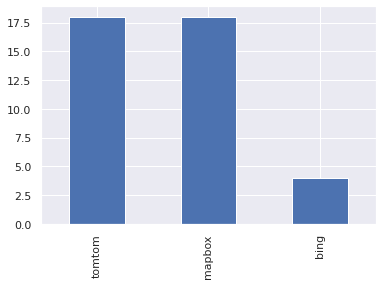

In [621]:
geocoded_data.sort_values("dist_to_median").tail(40).geocoder.value_counts().plot.bar()

In [622]:
def plot_address(geocoded_data, a):
    df = geocoded_data[geocoded_data.address==a]
    display(df)
    med=df[["median_point"]].drop_duplicates().set_geometry("median_point")

    ax = df.assign(label=df.geocoder + " ("+df.dist_to_median.astype(int).astype(str) + " - " + df.precision + ")").plot("label", 
                                                                                                  legend=True, 
                                                                                                  figsize=(10,10), 
                                                                                                  markersize=100)
    med.plot(ax=ax, color="red", marker="x", markersize=100)
    ax.set_title(a)
    
    add_basemap(ax)
    plt.show()    

address  \
0     Chaussée de Namur, 198, 5310 LEUZE, Belgique   
983   Chaussée de Namur, 198, 5310 LEUZE, Belgique   
1864  Chaussée de Namur, 198, 5310 LEUZE, Belgique   
2864  Chaussée de Namur, 198, 5310 LEUZE, Belgique   
3864  Chaussée de Namur, 198, 5310 LEUZE, Belgique   
4847  Chaussée de Namur, 198, 5310 LEUZE, Belgique   

                                               location           geocoder  \
0     (198, Chaussée de Namur, Leuze, Éghezée, Namur...  nominatim_wrapper   
983   (198, Chaussée de Namur, Leuze, Éghezée, Namur...    nominatim_local   
1864  (Chaussée de Namur 198, 5310 Eghezée, Belgique...               here   
2864  (Chaussée de Namur 198, Eghezée, Walloon Regio...               bing   
3864  (Chaussée De Namur 198, Eghezée, 5310 Namur, B...             mapbox   
4847  (Chaussée de Namur 198, 5310 Eghezée, (50.5556...             tomtom   

     precision                           point  is_in_belgium  \
0     building  POINT (546289.414 6543063.152)           True   
983   building  POINT (546289.414 6543063.152)           True   
1864  building  POINT (546289.269 6543064.817)           True   
2864  building  POINT (546289.269 6543063.065)           True   
3864  building  POINT (546289.380 6543062.890)           True   
4847  building  POINT (546289.269 6543063.065)           True   

                        median_point  dist_to_median  
0     POINT (546289.269 6543063.065)        0.168954  
983   POINT (546289.269 6543063.065)        0.168954  
1864  POINT (546289.269 6543063.065)        1.752156  
2864  POINT (546289.269 6543063.065)        0.000000  
3864  POINT (546289.269 6543063.065)        0.207587  
4847  POINT (546289.269 6543063.065)        0.000000

/home/vandy/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning:

The inferred zoom level of 29 is not valid for the current tile provider (valid zooms: 0 - 18).

/home/vandy/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning:

The inferred zoom level of 29 is not valid for the current tile provider (valid zooms: 0 - 19).



Default basemap doesn't work...


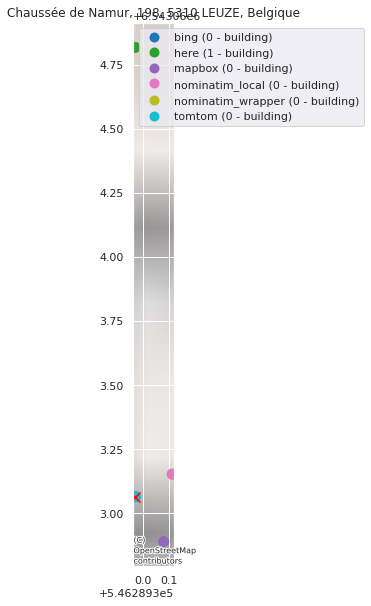

In [623]:
plot_address(geocoded_data, geocoded_data.iloc[0].address)

address  \
174   Avenue de l'Armé, 32, 1040 ETTERBEEK, Belgique   
2042  Avenue de l'Armé, 32, 1040 ETTERBEEK, Belgique   
3042  Avenue de l'Armé, 32, 1040 ETTERBEEK, Belgique   
4038  Avenue de l'Armé, 32, 1040 ETTERBEEK, Belgique   
5020  Avenue de l'Armé, 32, 1040 ETTERBEEK, Belgique   

                                               location           geocoder  \
174   (32, Avenue de l'Armée - Legerlaan, Etterbeek,...  nominatim_wrapper   
2042  (Avenue de l'Armée 32, 1040 Etterbeek, Belgiqu...               here   
3042  (Avenue de l'Armée 32, Brussels, Brussels-Capi...               bing   
4038  (Avenue De L'armée - Legerlaan 32, Etterbeek, ...             mapbox   
5020  (32 Avenue de l'Orme, Sainte-Angèle-de-Mérici ...             tomtom   

     precision                             point  is_in_belgium  \
174   building    POINT (490289.821 6592468.355)           True   
2042  building    POINT (490289.999 6592469.095)           True   
3042  building    POINT (490289.999 6592469.095)           True   
4038  building    POINT (490289.109 6592468.390)           True   
5020  building  POINT (-7578856.912 6194421.274)          False   

                        median_point  dist_to_median  
174   POINT (490289.821 6592468.390)    3.525379e-02  
2042  POINT (490289.821 6592468.390)    7.272245e-01  
3042  POINT (490289.821 6592468.390)    7.272245e-01  
4038  POINT (490289.821 6592468.390)    7.124447e-01  
5020  POINT (490289.821 6592468.390)    8.078959e+06

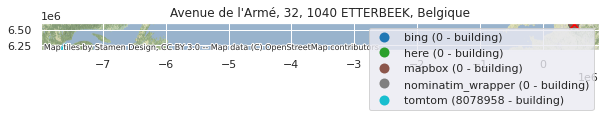

address  \
375   Rue de Danemark, 29, 1060 SAINT-GILLES, Belgique   
1322  Rue de Danemark, 29, 1060 SAINT-GILLES, Belgique   
2246  Rue de Danemark, 29, 1060 SAINT-GILLES, Belgique   
3246  Rue de Danemark, 29, 1060 SAINT-GILLES, Belgique   
4238  Rue de Danemark, 29, 1060 SAINT-GILLES, Belgique   
5219  Rue de Danemark, 29, 1060 SAINT-GILLES, Belgique   

                                               location           geocoder  \
375   (29, Rue de Danemark - Denemarkenstraat, Saint...  nominatim_wrapper   
1322  (29, Rue de Danemark - Denemarkenstraat, Saint...    nominatim_local   
2246  (Rue de Danemark 29, 1060 Saint-Gilles, Belgiq...               here   
3246  (Denmark, (56.03480911254883, 9.319060325622559))               bing   
4238  (Rue De Danemark - Denemarkenstraat 29, Saint-...             mapbox   
5219  (Rue de Danemark 29, 1060 Bruxelles, (50.83218...             tomtom   

     precision                            point  is_in_belgium  \
375   building   POINT (482598.657 6591660.801)           True   
1322  building   POINT (482598.657 6591660.801)           True   
2246  building   POINT (482598.936 6591660.060)           True   
3246   country  POINT (1037393.050 7565348.289)          False   
4238  building   POINT (482598.045 6591660.589)           True   
5219  building   POINT (482598.936 6591661.823)           True   

                        median_point  dist_to_median  
375   POINT (482598.797 6591660.695)    1.747736e-01  
1322  POINT (482598.797 6591660.695)    1.747736e-01  
2246  POINT (482598.797 6591660.695)    6.495847e-01  
3246  POINT (482598.797 6591660.695)    1.120653e+06  
4238  POINT (482598.797 6591660.695)    7.588116e-01  
5219  POINT (482598.797 6591660.695)    1.136561e+00

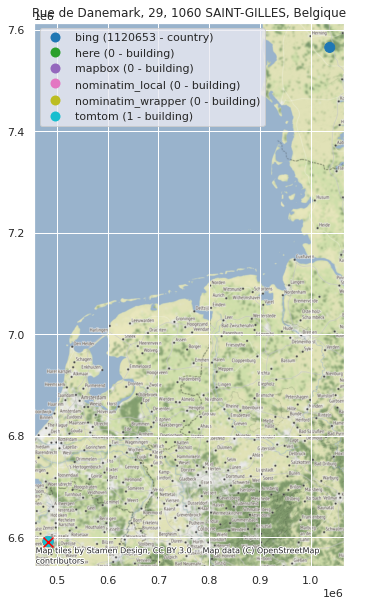

address  \
341   Boulevard Général Jacques, 212, 1050 IXELLES, ...   
1290  Boulevard Général Jacques, 212, 1050 IXELLES, ...   
2212  Boulevard Général Jacques, 212, 1050 IXELLES, ...   
3212  Boulevard Général Jacques, 212, 1050 IXELLES, ...   
4204  Boulevard Général Jacques, 212, 1050 IXELLES, ...   
5185  Boulevard Général Jacques, 212, 1050 IXELLES, ...   

                                               location           geocoder  \
341   (212, Boulevard Général Jacques - Generaal Jac...  nominatim_wrapper   
1290  (212, Boulevard Général Jacques - Generaal Jac...    nominatim_local   
2212  (Boulevard Général Jacques 212, 1050 Ixelles, ...               here   
3212  (Boulevard Général Jacques 212, Brussels, Brus...               bing   
4204  (Boulevard Général Jacques - Generaal Jacquesl...             mapbox   
5185  (212 Rue du Général Jacques de Montfort, 74700...             tomtom   

     precision                           point  is_in_belgium  \
341   building  POINT (488548.488 6589941.681)           True   
1290  building  POINT (488548.488 6589941.681)           True   
2212  building  POINT (488538.944 6589932.976)           True   
3212  building  POINT (488538.944 6589932.976)           True   
4204  building  POINT (488538.944 6589932.623)           True   
5185    street  POINT (738333.202 5770955.493)          False   

                        median_point  dist_to_median  
341   POINT (488538.944 6589932.976)       12.917674  
1290  POINT (488538.944 6589932.976)       12.917674  
2212  POINT (488538.944 6589932.976)        0.000000  
3212  POINT (488538.944 6589932.976)        0.000000  
4204  POINT (488538.944 6589932.976)        0.352429  
5185  POINT (488538.944 6589932.976)   856225.022316

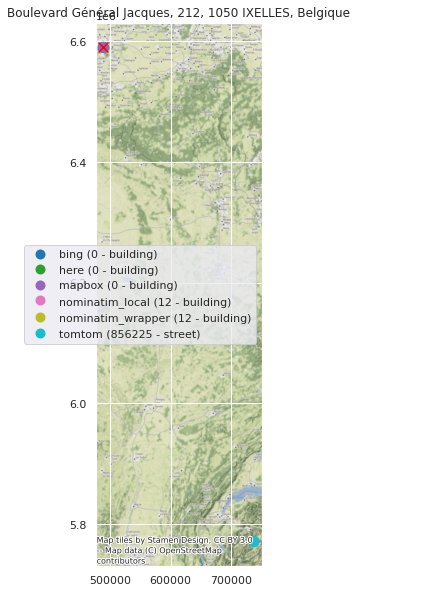

address  \
518   Rue du Luxembourg, 35, 1050 IXELLES, Belgique   
1445  Rue du Luxembourg, 35, 1050 IXELLES, Belgique   
2391  Rue du Luxembourg, 35, 1050 IXELLES, Belgique   
3391  Rue du Luxembourg, 35, 1050 IXELLES, Belgique   
4381  Rue du Luxembourg, 35, 1050 IXELLES, Belgique   
5362  Rue du Luxembourg, 35, 1050 IXELLES, Belgique   

                                               location           geocoder  \
518   (Hotel Leopold Brussels EU, 35, Rue du Luxembo...  nominatim_wrapper   
1445  (Hotel Leopold Brussels EU, 35, Rue du Luxembo...    nominatim_local   
2391  (Rue du Luxembourg 35, 1050 Ixelles, Belgique,...               here   
3391  (35 Rue du Mur, Luxembourg, Luxembourg L-2174,...               bing   
4381  (Rue Du Luxembourg - Luxemburgstraat 35, Ixell...             mapbox   
5362  (Rue du Luxembourg 35, 1050 Bruxelles, (50.839...             tomtom   

      precision                           point  is_in_belgium  \
518    building  POINT (486538.922 6592949.037)           True   
1445  [UNKNOWN]  POINT (486538.922 6592949.037)           True   
2391   building  POINT (486544.098 6592943.272)           True   
3391   building  POINT (683866.801 6377333.575)          False   
4381   building  POINT (486543.764 6592941.686)           True   
5362   building  POINT (486545.212 6592943.272)           True   

                        median_point  dist_to_median  
518   POINT (486544.098 6592943.272)        7.747397  
1445  POINT (486544.098 6592943.272)        7.747397  
2391  POINT (486544.098 6592943.272)        0.000000  
3391  POINT (486544.098 6592943.272)   292273.486313  
4381  POINT (486544.098 6592943.272)        1.621280  
5362  POINT (486544.098 6592943.272)        1.113195

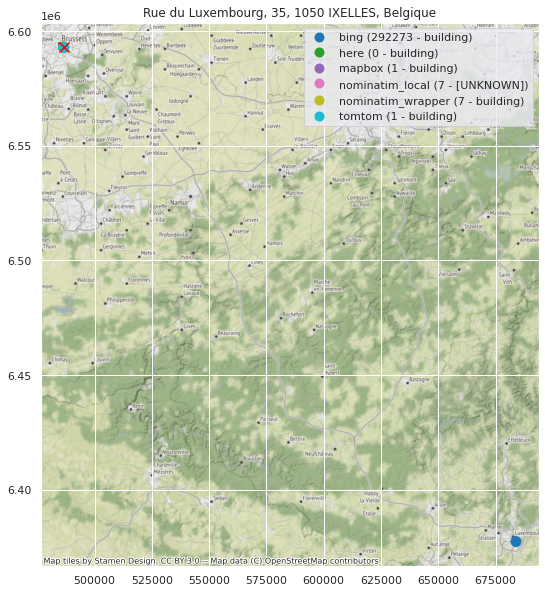

address  \
712   Rue du Luxembourg, 68, 1000 BRUXELLES CENTRE, ...   
1627  Rue du Luxembourg, 68, 1000 BRUXELLES CENTRE, ...   
2590  Rue du Luxembourg, 68, 1000 BRUXELLES CENTRE, ...   
3590  Rue du Luxembourg, 68, 1000 BRUXELLES CENTRE, ...   
4578  Rue du Luxembourg, 68, 1000 BRUXELLES CENTRE, ...   
5559  Rue du Luxembourg, 68, 1000 BRUXELLES CENTRE, ...   

                                               location           geocoder  \
712   (68, Rue du Luxembourg - Luxemburgstraat, Brux...  nominatim_wrapper   
1627  (68, Rue du Luxembourg - Luxemburgstraat, Brux...    nominatim_local   
2590  (Rue du Luxembourg 68, 1000 Bruxelles, Belgiqu...               here   
3590  (68 Rue du Centre, Reckange-sur-Mess, Esch-sur...               bing   
4578  (Rue Du Luxembourg - Luxemburgstraat 68, Bruss...             mapbox   
5559  (Rue du Luxembourg 68, 1000 Bruxelles, (50.839...             tomtom   

     precision                           point  is_in_belgium  \
712   building  POINT (486693.834 6592945.740)           True   
1627  building  POINT (486693.834 6592945.740)           True   
2590  building  POINT (486693.267 6592945.035)           True   
3590  building  POINT (669988.600 6367662.287)          False   
4578  building  POINT (486693.934 6592946.445)           True   
5559  building  POINT (486694.380 6592946.798)           True   

                        median_point  dist_to_median  
712   POINT (486693.934 6592945.740)        0.100188  
1627  POINT (486693.934 6592945.740)        0.100188  
2590  POINT (486693.934 6592945.740)        0.971238  
3590  POINT (486693.934 6592945.740)   290429.972530  
4578  POINT (486693.934 6592945.740)        0.705117  
5559  POINT (486693.934 6592945.740)        1.147584

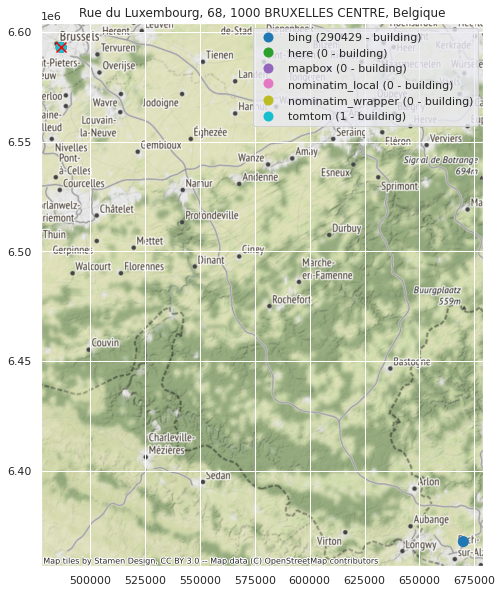

In [624]:
for a in geocoded_data.sort_values("dist_to_median", ascending=False).address.unique()[0:5]:
    #print(a)
    plot_address(geocoded_data, a)
   

In [625]:
# geocoders["bing"].geocode("Rue Le Lorrain, 4, 1080 Molenbeek-Saint-Jean, Belgique")

In [626]:
# geocoded_data.loc[25].location.raw

## Median pertinence

How many close to median ?

In [627]:
nb_close_to_median = geocoded_data.assign(close_to_median = geocoded_data.dist_to_median < 100).groupby("address").close_to_median.sum()

nb_close_to_median

address
Aachener Strasse, 140, 4731 EYNATTEN, Belgique         6
Aarschotsesteenweg, 6, 2230 HERSELT, Belgique          6
Adolphe Demeurlaan, 41, 1060 SAINT-GILLES, Belgique    6
Albert Meunierstraat, 110, 1160 AUDERGHEM, Belgique    6
Amerikaansestraat, 119, 1050 IXELLES, Belgique         3
                                                      ..
rue du Centre, 200, 4950 WAIMES, Belgique              0
rue du Collège, 1, 5310 EGHEZEE, Belgique              4
rue du Trône, 65, 1050 IXELLES, Belgique               6
rue du Vieux Frêne, 3, 4100 SERAING, Belgique          3
rue francart, 11, 1050 IXELLES, Belgique               6
Name: close_to_median, Length: 1000, dtype: int64

In [628]:
nb_close_to_median.value_counts()

6    662
4    153
3     53
5     51
2     44
0     32
1      5
Name: close_to_median, dtype: int64

address  \
537   Avenue de L'Exposition, 266, 1090 JETTE, Belgique   
1462  Avenue de L'Exposition, 266, 1090 JETTE, Belgique   
2410  Avenue de L'Exposition, 266, 1090 JETTE, Belgique   
3410  Avenue de L'Exposition, 266, 1090 JETTE, Belgique   
4400  Avenue de L'Exposition, 266, 1090 JETTE, Belgique   
5381  Avenue de L'Exposition, 266, 1090 JETTE, Belgique   

                                               location           geocoder  \
537   (Avenue de l'Exposition - Tentoonstellingslaan...  nominatim_wrapper   
1462  (Avenue de l'Exposition - Tentoonstellingslaan...    nominatim_local   
2410  (Avenue de l'Exposition 264, 1090 Jette, Belgi...               here   
3410  (Avenue de l'Exposition, Brussels, Brussels-Ca...               bing   
4400  (Avenue De L'exposition - Tentoonstellingslaan...             mapbox   
5381  (Avenue de l'Exposition, 1090 Bruxelles, (50.8...             tomtom   

     precision                           point  is_in_belgium  \
537     street  POINT (480488.429 6600410.337)           True   
1462    street  POINT (480488.429 6600410.337)           True   
2410  building  POINT (480633.033 6600847.901)           True   
3410    street  POINT (480550.657 6601317.267)           True   
4400  building  POINT (480559.451 6601268.212)           True   
5381    street  POINT (480550.657 6601317.267)           True   

                        median_point  dist_to_median  
537   POINT (480596.242 6601058.056)      656.630551  
1462  POINT (480596.242 6601058.056)      656.630551  
2410  POINT (480596.242 6601058.056)      213.351855  
3410  POINT (480596.242 6601058.056)      263.188947  
4400  POINT (480596.242 6601058.056)      213.351855  
5381  POINT (480596.242 6601058.056)      263.188947

/home/vandy/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning:

The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 18).



Default basemap doesn't work...


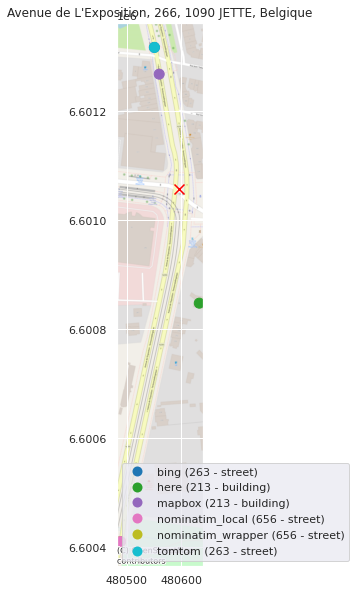

address  \
835   Chaussée de Dinant, 126, 5100 WEPION, Belgique   
1741  Chaussée de Dinant, 126, 5100 WEPION, Belgique   
2716  Chaussée de Dinant, 126, 5100 WEPION, Belgique   
3716  Chaussée de Dinant, 126, 5100 WEPION, Belgique   
4702  Chaussée de Dinant, 126, 5100 WEPION, Belgique   
5683  Chaussée de Dinant, 126, 5100 WEPION, Belgique   

                                               location           geocoder  \
835   (Chaussée de Dinant, Wépion, Namur, Wallonie, ...  nominatim_wrapper   
1741  (Chaussée de Dinant, Wépion, Namur, Wallonie, ...    nominatim_local   
2716  (Chaussée de Dinant 42, 5100 Namur, Belgique, ...               here   
3716  (Chaussée de Dinant, Namur, Walloon Region 500...               bing   
4702  (Chaussée De Dinant 126, Namur, 5000 Namur, Be...             mapbox   
5683   (Chaussée de Dinant, Namur, (50.41319, 4.88032))             tomtom   

     precision                           point  is_in_belgium  \
835     street  POINT (542124.640 6520383.593)           True   
1741    street  POINT (542124.640 6520383.593)           True   
2716  building  POINT (543004.776 6514124.207)           True   
3716    street  POINT (543274.737 6518142.965)           True   
4702  building  POINT (540594.832 6524277.844)           True   
5683    street  POINT (543274.737 6518142.965)           True   

                        median_point  dist_to_median  
835   POINT (541799.804 6519201.026)     1226.369921  
1741  POINT (541799.804 6519201.026)     1226.369921  
2716  POINT (541799.804 6519201.026)     5217.858335  
3716  POINT (541799.804 6519201.026)     1815.191467  
4702  POINT (541799.804 6519201.026)     5217.858335  
5683  POINT (541799.804 6519201.026)     1815.191467

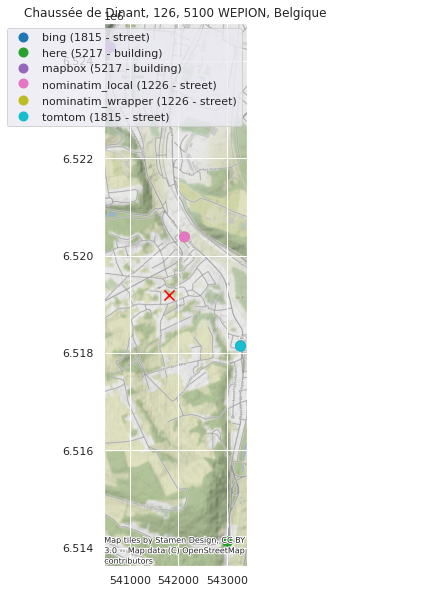

address  \
935   Lammerdries-Winkelstraat, 4 B2, 2250 OLEN, Bel...   
2816  Lammerdries-Winkelstraat, 4 B2, 2250 OLEN, Bel...   
3816  Lammerdries-Winkelstraat, 4 B2, 2250 OLEN, Bel...   
4799  Lammerdries-Winkelstraat, 4 B2, 2250 OLEN, Bel...   
5779  Lammerdries-Winkelstraat, 4 B2, 2250 OLEN, Bel...   

                                               location           geocoder  \
935   (Lammerdries-Winkelstraat, Geel-Olen-De Heze, ...  nominatim_wrapper   
2816  (Lammerdries-Winkelstraat 4, 2250 Olen, België...               here   
3816  (Lammerdries-Winkelstraat 2, Olen, Flemish Reg...               bing   
4799  (Lammerdries-Winkelstraat 4, Olen, 2250 Antwer...             mapbox   
5779  (Lammerdries-Winkelstraat 2, 2250 Olen, (51.15...             tomtom   

     precision                           point  is_in_belgium  \
935     street  POINT (546122.134 6648293.206)           True   
2816  building  POINT (545689.257 6648340.289)           True   
3816  building  POINT (545685.917 6648070.535)           True   
4799  building  POINT (545539.978 6648181.630)           True   
5779    street  POINT (545685.917 6648070.535)           True   

                        median_point  dist_to_median  
935   POINT (545685.917 6648181.630)      450.259983  
2816  POINT (545685.917 6648181.630)      158.694423  
3816  POINT (545685.917 6648181.630)      111.095160  
4799  POINT (545685.917 6648181.630)      145.939852  
5779  POINT (545685.917 6648181.630)      111.095160

/home/vandy/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning:

The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 18).



Default basemap doesn't work...


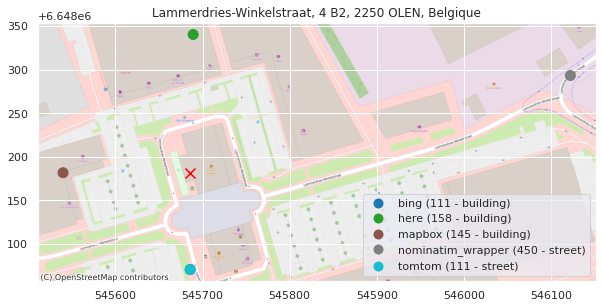

In [629]:
for a in nb_close_to_median[nb_close_to_median==0].iloc[0:10].index:
    #print(a)
    if geocoded_data[geocoded_data.address == a].median_point.notnull().any():
        plot_address(geocoded_data[geocoded_data.median_point.notnull()], a)
  

# Statistics

## Add selectors

In [630]:
geocoded_data["is_value_normal"]    = geocoded_data.dist_to_median < geocoded_data.dist_to_median.quantile(0.99)
geocoded_data.is_value_normal.value_counts()

True     5678
False     149
Name: is_value_normal, dtype: int64

In [631]:
geocoded_data["is_median_reliable"] =   geocoded_data.address.isin(nb_close_to_median[nb_close_to_median>2].index)
geocoded_data.is_median_reliable.value_counts()

True     5409
False     418
Name: is_median_reliable, dtype: int64

In [632]:
match_per_addr = geocoded_data.groupby("address").geocoder.count()
geocoded_data["has_enough_matches"] = geocoded_data.address.isin(match_per_addr[match_per_addr>=4].index)
geocoded_data["has_enough_matches"].value_counts()

True     5815
False      12
Name: has_enough_matches, dtype: int64

In [633]:
pd.crosstab(geocoded_data["is_median_reliable"] , geocoded_data["has_enough_matches"])

has_enough_matches  False  True 
is_median_reliable              
False                   6    412
True                    6   5403

In [634]:
geocoded_data["is_reliable"] = geocoded_data["is_value_normal"] & \
                               geocoded_data["is_median_reliable"] & \
                               geocoded_data["has_enough_matches"] &  \
                               geocoded_data["is_in_belgium"]

In [635]:
pd.crosstab(geocoded_data["is_in_belgium"] , geocoded_data["is_value_normal"])

is_value_normal  False  True 
is_in_belgium                
False                5      6
True               144   5672

In [636]:
geocoded_data[~geocoded_data.is_value_normal].geocoder.value_counts()

bing                 32
nominatim_wrapper    28
mapbox               28
tomtom               27
here                 25
nominatim_local       9
Name: geocoder, dtype: int64

In [637]:
geocoded_data[~geocoded_data.is_reliable & (geocoded_data.geocoder=="nominatim_wrapper")]

address  \
3            rue du Centre, 200, 4950 WAIMES, Belgique   
13      rue des Charmilles, 67, 4950 MALMEDY, Belgique   
23    Rue de la Gare Fleurie, 16, 5100 NAMUR, Belgique   
32             rue Roi Albert, 4, 4130 TILFF, Belgique   
35   Rue d'Alleur 27c, 4000 Liège, 27c, 4000 LIEGE,...   
..                                                 ...   
924      Rue de Bruxelles, 10/17, 4340 AWANS, Belgique   
935  Lammerdries-Winkelstraat, 4 B2, 2250 OLEN, Bel...   
969      Avenue de l'Ermitage, 1, 5000 NAMUR, Belgique   
971      Route du Condroz, 541, 4031 ANGLEUR, Belgique   
973                Saint Remy, 9, 4000 LIEGE, Belgique   

                                              location           geocoder  \
3    (Rue du Centre, Waimes, Verviers, Liège, Wallo...  nominatim_wrapper   
13   (Rue des Charmilles, Xhoffraix, Malmedy, Vervi...  nominatim_wrapper   
23   (Rue de la Gare Fleurie, Velaine, Jambes, Namu...  nominatim_wrapper   
32   (4, Rue du Roi Albert, Ougrée, Seraing, Liège,...  nominatim_wrapper   
35   (27, Rue Prince-de-Liège, Bois-de-Breux, Jupil...  nominatim_wrapper   
..                                                 ...                ...   
924  (Rue de Bruxelles, Hognoul, Awans, Liège, Wall...  nominatim_wrapper   
935  (Lammerdries-Winkelstraat, Geel-Olen-De Heze, ...  nominatim_wrapper   
969  (Château de Namur, 1, Avenue de l'Ermitage, La...  nominatim_wrapper   
971  (Route du Condroz, Angleur, Liège, Wallonie, 4...  nominatim_wrapper   
973  (Saint-Remy, Rue Sondeville, Sous les Vignes, ...  nominatim_wrapper   

    precision                           point  is_in_belgium  \
3      street  POINT (680379.741 6518655.149)           True   
13     street  POINT (675668.889 6526400.737)           True   
23     street  POINT (542734.381 6525367.555)           True   
32   building  POINT (616101.017 6550836.026)           True   
35   building  POINT (626234.634 6555931.564)           True   
..        ...                             ...            ...   
924    street  POINT (609206.222 6564755.127)           True   
935    street  POINT (546122.134 6648293.206)           True   
969  building  POINT (540519.281 6525413.958)           True   
971    street  POINT (621743.512 6552500.995)           True   
973  building  POINT (628918.498 6569708.609)           True   

                       median_point  dist_to_median  is_value_normal  \
3                              None             NaN            False   
13   POINT (677732.763 6528198.524)     2737.081336             True   
23   POINT (542633.537 6525236.601)      165.283779             True   
32   POINT (618853.970 6548194.640)     3815.189576             True   
35   POINT (616948.203 6564704.251)    12774.891373            False   
..                              ...             ...              ...   
924  POINT (609065.113 6564850.941)      170.564026             True   
935  POINT (545685.917 6648181.630)      450.259983             True   
969  POINT (540369.571 6525403.957)      150.043260             True   
971  POINT (618349.715 6545511.715)     7769.677410            False   
973  POINT (620090.752 6557652.131)    14942.816461            False   

     is_median_reliable  has_enough_matches  is_reliable  
3                 False                True        False  
13                False                True        False  
23                False                True        False  
32                False                True        False  
35                 True                True        False  
..                  ...                 ...          ...  
924               False                True        False  
935               False                True        False  
969               False                True        False  
971               False                True        False  
973                True                True        False  

[82 rows x 12 columns]

In [638]:
geocoded_data.geocoder.value_counts()

bing                 1000
here                 1000
nominatim_wrapper     983
mapbox                983
tomtom                980
nominatim_local       881
Name: geocoder, dtype: int64

## Matching rate

In [639]:
mr = (geocoded_data.groupby("geocoder").address.count()/ data.shape[0])

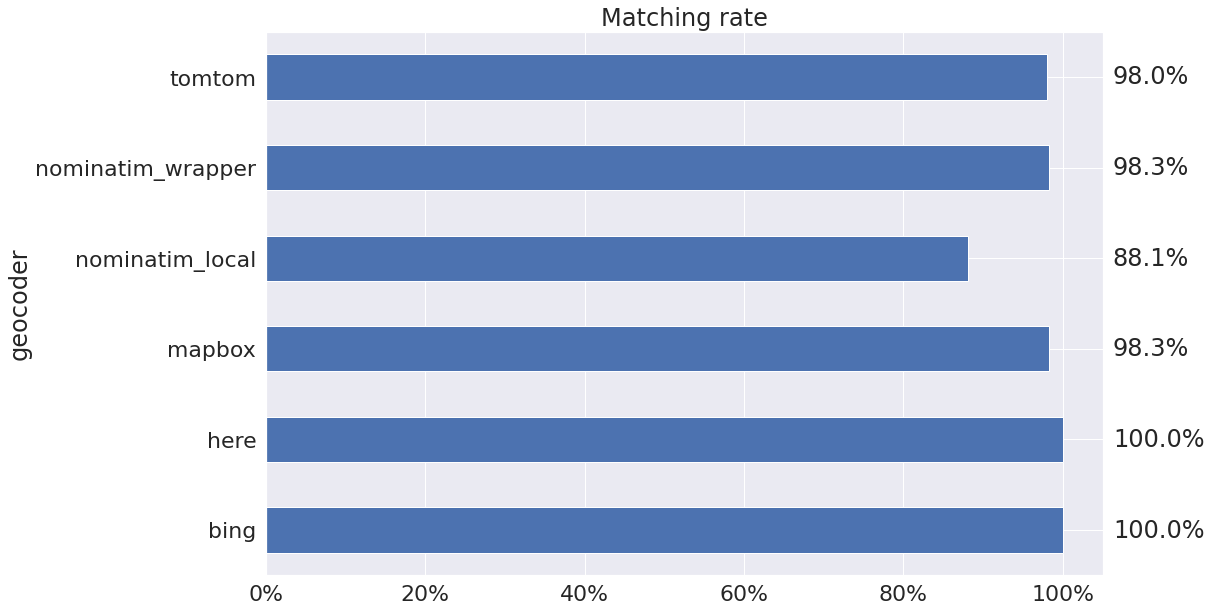

In [640]:
def show_values_on_hbars(ax):
    for p in ax.patches:
        plt.annotate(f"{p.get_width():.1%}", # this is the text
                 (1,p.get_y()+p.get_height()/2), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(50,0), # distance from text to points (x,y)
                 ha='left', va="center") # horizontal alignment can be left, right or center
        

plt.figure(figsize=(15,10))
sbn.set(font_scale=2)

mr_plot=mr.rename("matching rate").plot.barh(title="Matching rate")
show_values_on_hbars(mr_plot)
mr_plot.xaxis.set_major_formatter('{x:.0%}')

img_name=f"{fig_path}/matching_rate_{dataset}.png"
plt.savefig(img_name,  bbox_inches='tight')
pdf_add_image(pdf, img_name)

sbn.set(font_scale=1)


In [641]:
# # Only reliable records
# mr = (geocoded_data[geocoded_data.is_reliable].groupby("geocoder").address.count()/ geocoded_data[geocoded_data.is_reliable].address.nunique())

# plt.figure(figsize=(15,10))
# sbn.set(font_scale=2)

# mr_plot=mr.rename("matching rate").plot.barh(title="Matching rate (only reliable)")
# show_values_on_hbars(mr_plot)
# mr_plot.xaxis.set_major_formatter('{x:.0%}')
# # mr.reset_index()
# plt.savefig(f"{fig_path}/matching_rate_reliable_{dataset}.png", bbox_inches='tight')

# pdf.add_page()
# pdf.image(f"{fig_path}/matching_rate_reliable_{dataset}.png",0,0, 210)

# sbn.set(font_scale=1)

<AxesSubplot:title={'center':'Number of success per address'}>

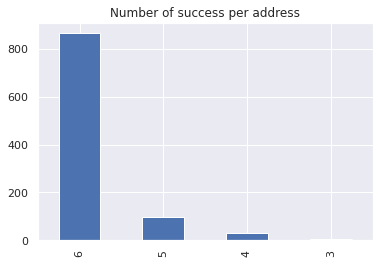

In [642]:
geocoded_data.groupby("address").geocoder.count().value_counts().sort_index(ascending=False).plot.bar(title="Number of success per address")

## Precision

In [643]:
# geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack().plot.bar(stacked=True)
# plt.savefig(f"{fig_path}/matching_rate_precision_{dataset}.png")

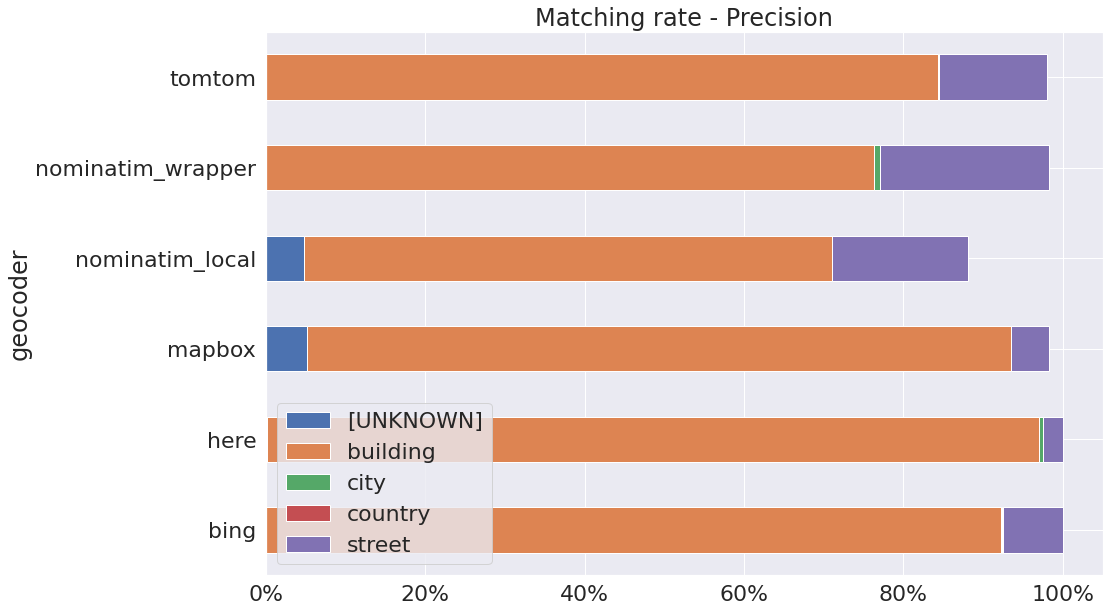

In [644]:
sbn.set(font_scale=2)
mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
mr_prec = mr_prec/data.shape[0]
mr_prec_plot= mr_prec.plot.barh(stacked=True, figsize=(15,10), title="Matching rate - Precision")
mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')

plt.legend(loc='lower left')

img_name=f"{fig_path}/matching_rate_precision_{dataset}.png"
plt.savefig(img_name,  bbox_inches='tight')
pdf_add_image(pdf, img_name)

sbn.set(font_scale=1)


In [645]:
mr_prec

precision          [UNKNOWN]  building   city  country  street
geocoder                                                      
bing                     NaN     0.923  0.001    0.001   0.075
here                   0.002     0.968  0.005      NaN   0.025
mapbox                 0.052     0.883    NaN      NaN   0.048
nominatim_local        0.048     0.663    NaN      NaN   0.170
nominatim_wrapper        NaN     0.763  0.008      NaN   0.212
tomtom                   NaN     0.844  0.001      NaN   0.135

## Distance to median

### Average

geocoder
bing                 2033.156170
here                  221.583397
mapbox                391.013746
nominatim_local       227.658977
nominatim_wrapper     320.176535
tomtom               9553.551650
Name: dist_to_median, dtype: float64

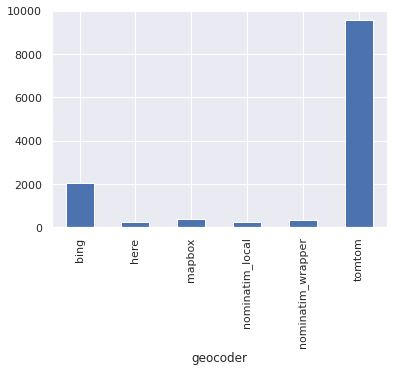

In [646]:
d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
plt.savefig(f"{fig_path}/dist2med_{dataset}.png")
d2m

In [647]:
# geocoded_data.pivot(index="address", columns="geocoder", values="dist_to_median").plot.box()

In [648]:
# # skipping top 1%
# d2m = geocoded_data[geocoded_data.is_value_normal].groupby("geocoder").dist_to_median.mean()
# d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_skip1pc_{dataset}.png")
# d2m

In [649]:
# geocoded_data[geocoded_data.is_value_normal].pivot(index="address", columns="geocoder", values="dist_to_median").plot.box()

geocoder
bing                  11.920441
here                  26.340876
mapbox                98.447791
nominatim_local       94.987928
nominatim_wrapper    124.071089
tomtom                11.815508
Name: dist_to_median, dtype: float64

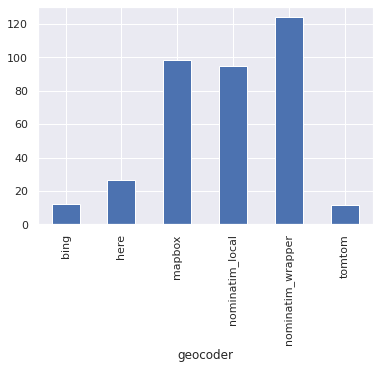

In [650]:
# skipping non reliable median

d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

In [651]:
# geocoded_data[geocoded_data.is_reliable].pivot(index="address", columns="geocoder", values="dist_to_median").plot.box()

In [652]:
# geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.mean().unstack().plot.bar()

In [653]:
#  geocoded_data[geocoded_data.is_reliable].groupby(["geocoder", "precision"]).dist_to_median.mean().unstack().plot.bar(figsize=(15,10))

In [654]:
# dist2med= geocoded_data[geocoded_data.is_reliable].groupby(["geocoder", "precision"]).dist_to_median.mean().unstack().fillna(0)
# dist2med

In [655]:
# mr_prec#.shape

In [656]:
# a = geocoded_data[geocoded_data.precision=="[UNKNOWN]"].pivot(index="address", columns="geocoder", values="dist_to_median")
# a

In [657]:
# Boxplot: 
# box: Q1-median(Q2)-Q3
# top whisker:    highest point that falls within Q3 + (Q3-Q1 = IQR) * 1.5 
# bottom whisker: lowest  point that falls within Q1 - (IQR) * 1.5 

def show_precision_stats(geocoded_data, title):
    
    mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
    dist2med= geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.mean().unstack()
    
    mr_prec["all"] = geocoded_data.groupby(["geocoder"]).address.count()
    dist2med["all"] = geocoded_data.groupby(["geocoder"]).dist_to_median.mean()
    
    fig, ax =plt.subplots(mr_prec.shape[1], 3, figsize=(15, 20)) #
    fig.suptitle(title)
#     plt.gca().set_title(title)
    filters = [(r, (geocoded_data.precision==r)) for r in geocoded_data.precision.unique()]
    filters.append(("all", geocoded_data.precision.notnull()))
    
    colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]
    for i, (r, fltr) in enumerate(filters): 
        #print(r, i)
        dist2med[r].plot.bar(ax=ax[i][0], color=colors)
        #plt.show()
        d = geocoded_data[fltr].pivot(index="address", columns="geocoder", values="dist_to_median")
        d  =d.reindex(mr_prec.index, axis=1)

        d.plot.box(ax=ax[i][1], rot=90)

        mr_prec[r].plot.bar(ax=ax[i][2], color=colors)

        plt.setp(ax[i, 0], ylabel=r)
        #plt.setp(axs[:, 0], ylabel='y axis label')

    plt.setp(ax[0, 0], title="Average distance")
    plt.setp(ax[0, 1], title="Distance distribution")
    plt.setp(ax[0, 2], title="Number of matches")


In [658]:
# geocoded_data.groupby(["geocoder"]).address.count()#.unstack()
# geocoded_data.groupby(["geocoder"]).dist_to_median.mean()#.unstack()

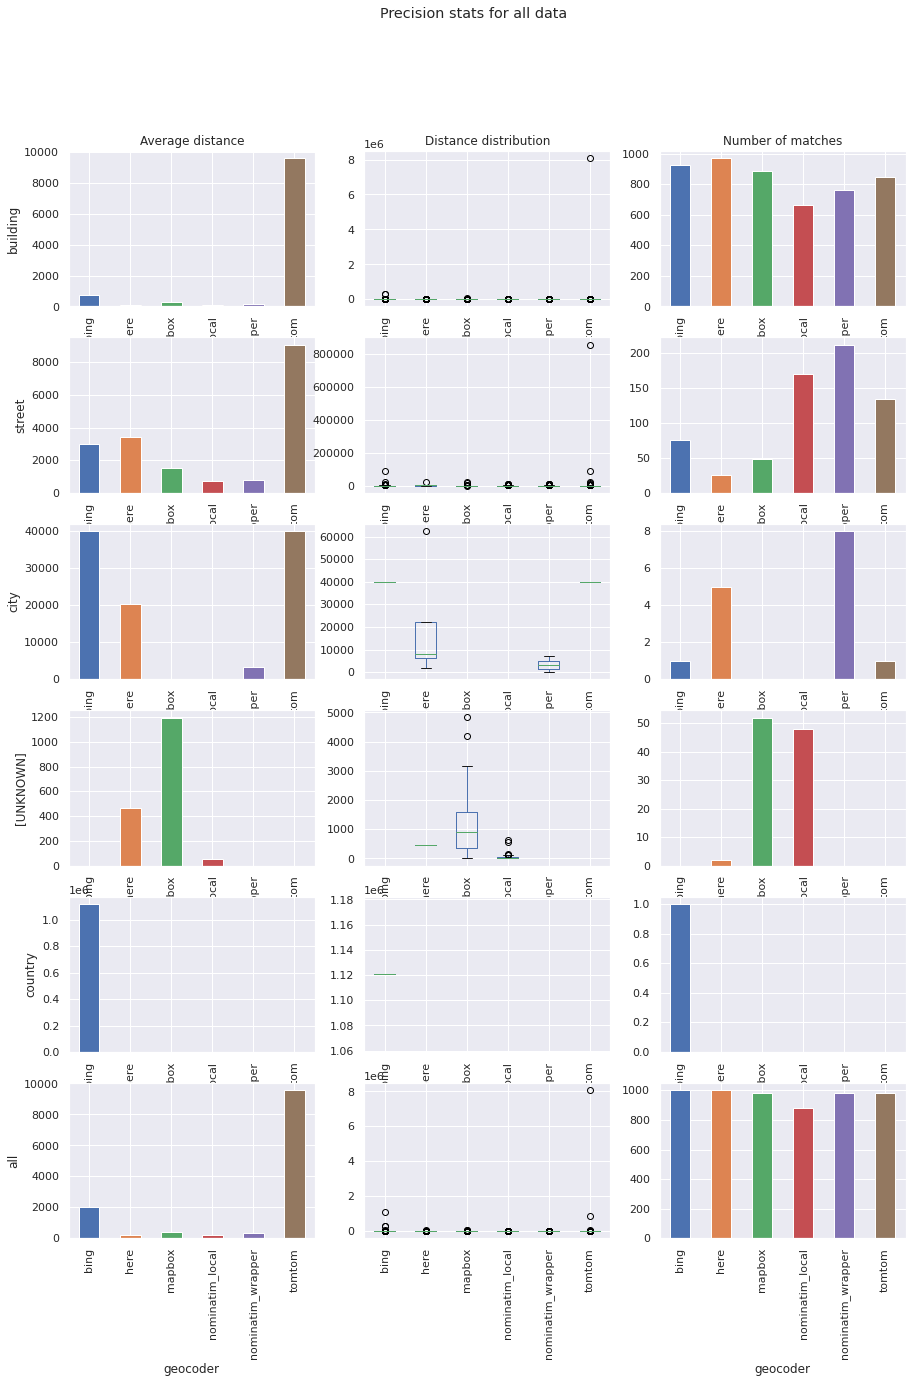

In [659]:
show_precision_stats(geocoded_data, "Precision stats for all data")

img_name=f"{fig_path}/precision_stats_{dataset}.png"
plt.savefig(img_name,  bbox_inches='tight')
pdf_add_image(pdf, img_name, orientation='P', width=200)


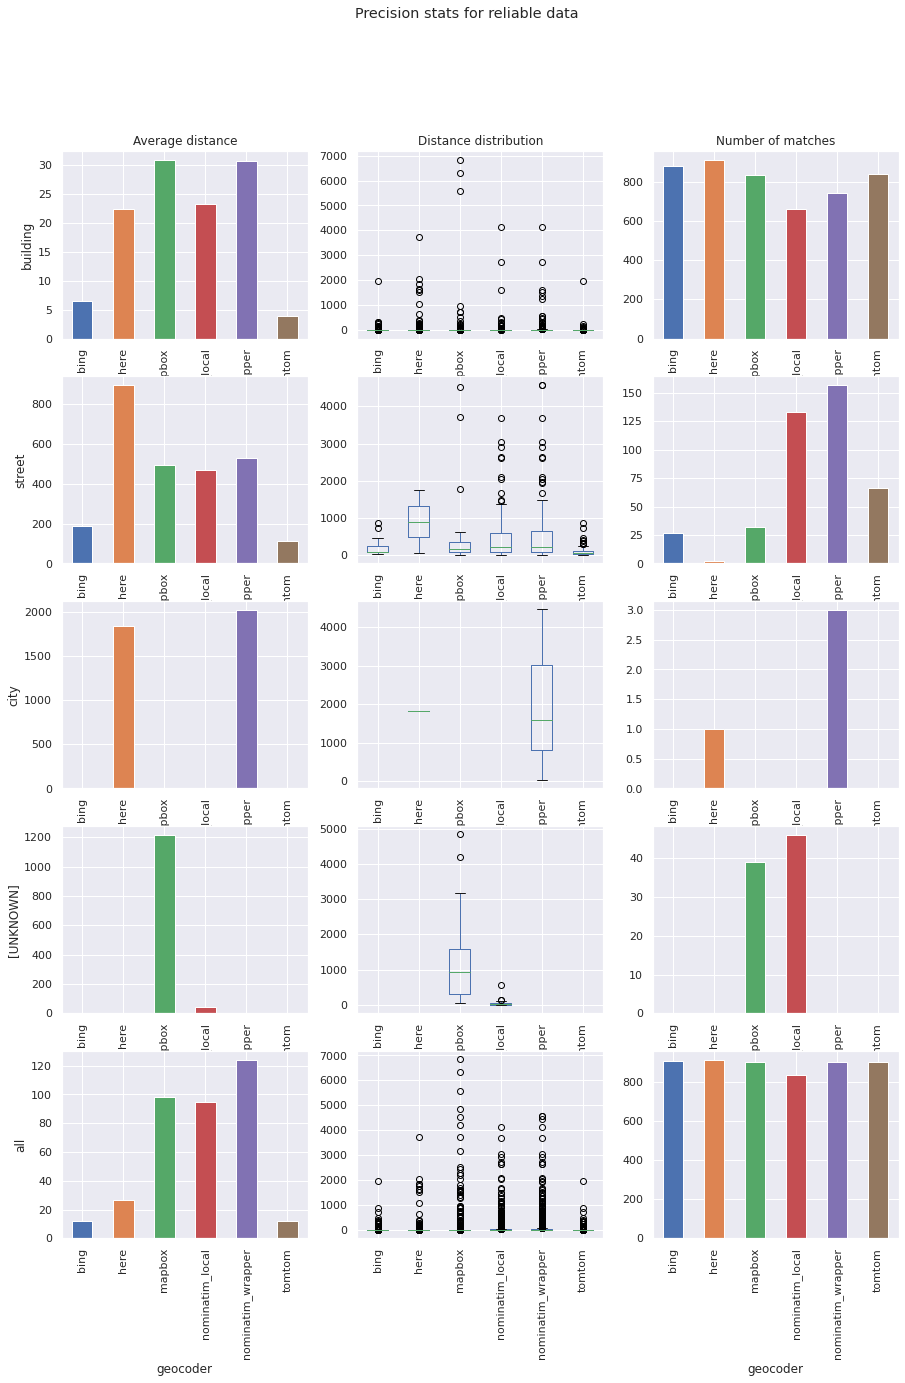

In [660]:
show_precision_stats(geocoded_data[geocoded_data.is_reliable], "Precision stats for reliable data")

img_name=f"{fig_path}/precision_stats_reliable_{dataset}.png"
plt.savefig(img_name,  bbox_inches='tight')
pdf_add_image(pdf, img_name, orientation='P', width=200)


### Distribution

In [661]:
def plot_dist_to_median_distrib(geocoded_data, plotter="px", title=None, filename=None):
    tics = sorted([10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)])
    geocoded_data = geocoded_data.assign(dist_to_median_bins = pd.cut(geocoded_data.dist_to_median, tics, include_lowest=True))
    df = geocoded_data.groupby(["dist_to_median_bins","geocoder"]).address.count().unstack()

    title = 'Distance to median'+(f" ({title})" if title else"")
    if plotter=="plt":

        df.plot(figsize=(15,10), title=title)#.hist()
        if filename:
            plt.savefig(filename, bbox_inches='tight')

            
    else:
        df = df.reset_index()
        df["x"] = df.dist_to_median_bins.apply(lambda x: x.right)
        fig = px.line(df, x="x", y=geocoded_data.geocoder.unique(), title=title, log_x=True)
        fig.show()

    #plt.savefig(f"{fig_path}/dist2med_distrib_{dataset}.png")

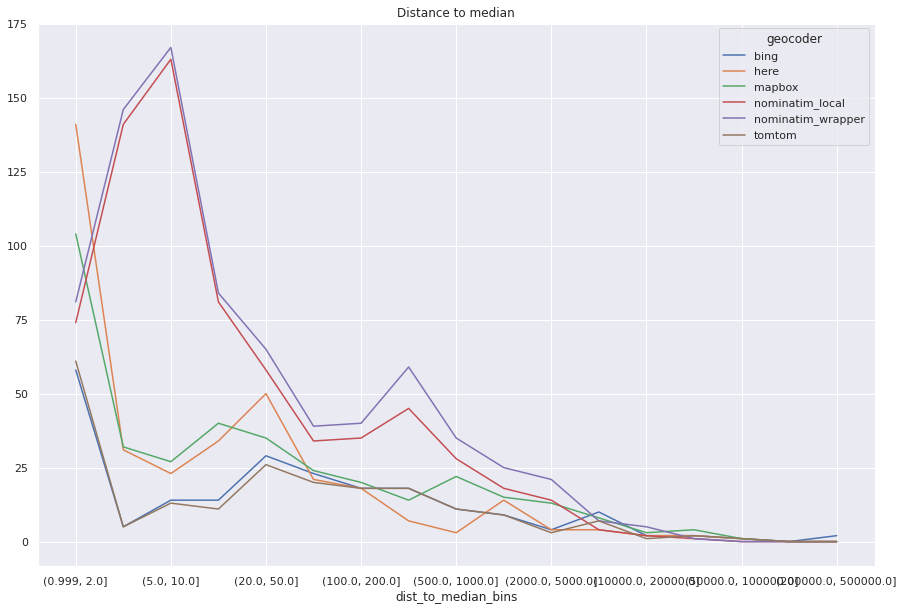

In [662]:
img_name=f"{fig_path}/dist2med_distrib_{dataset}.png"

plot_dist_to_median_distrib(geocoded_data, "plt", 
                            filename=img_name)

pdf_add_image(pdf, img_name)


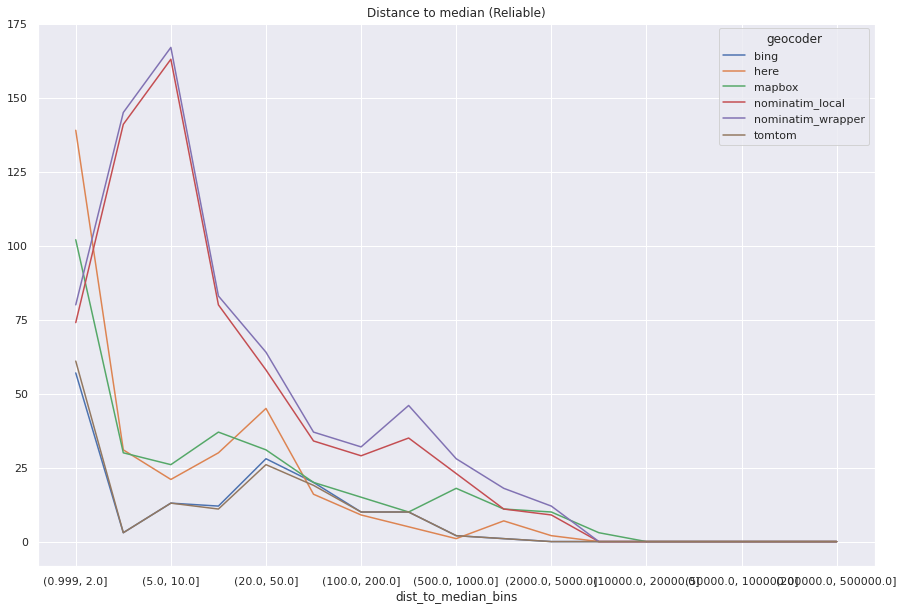

In [663]:
img_name=f"{fig_path}/dist2med_distrib_reliable_{dataset}.png"

plot_dist_to_median_distrib(geocoded_data[geocoded_data.is_reliable], "plt", 
                            title="Reliable", 
                            filename=img_name)
pdf_add_image(pdf, img_name)



In [664]:
addresses_found_by_NW = geocoded_data[(geocoded_data.geocoder == "nominatim_wrapper") & (geocoded_data.precision == "building")].address
plot_dist_to_median_distrib(geocoded_data[geocoded_data.address.isin(addresses_found_by_NW)], 
                            title="for addr. found by NW at build. level")


### Ratio

In [665]:
def plot_threshold_ratio(geocoded_data, plotter="px", title=None, filename=None):
    thresh_ratio = pd.DataFrame()
    for gc in geocoded_data.geocoder.unique():
        g_data = geocoded_data[geocoded_data.geocoder == gc]
        for thresh in [10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)]:
            thresh_ratio = thresh_ratio.append({"geocoder": gc, 
                                                "threshold": thresh, 
                                                "ratio": g_data[g_data.dist_to_median <= thresh].shape[0]/g_data.shape[0]}, ignore_index=True)
    
    df = thresh_ratio.set_index("threshold").pivot(columns="geocoder", values="ratio")
    
    title = 'Ratio below threshold'+(f" ({title})" if title else"")
    if plotter=="plt":
        df.plot.line(logx=True, figsize=(15,10),  title=title)#x="ratio", y="threshold")
        if filename:
             plt.savefig(filename, bbox_inches='tight')
    else :
        fig = px.line(df, y=geocoded_data.geocoder.unique(), title=title, log_x=True)
        fig.show()

    ##return thresh_ratio

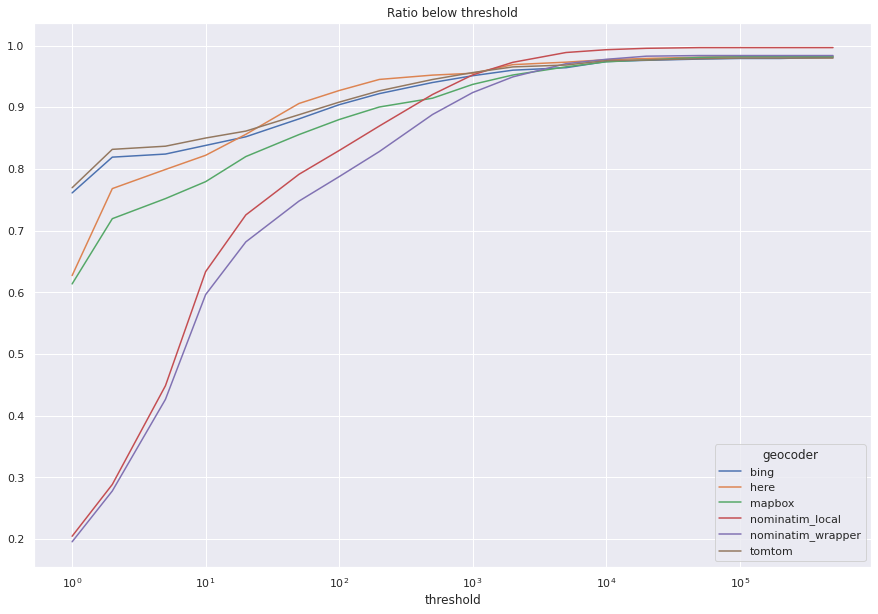

In [666]:
img_name=f"{fig_path}/dist2med_thresholds_{dataset}.png"

plot_threshold_ratio(geocoded_data, "plt", filename=img_name)

pdf_add_image(pdf, img_name)

# plt.savefig(f"{fig_path}/dist2med_thresholds_{dataset}.png")

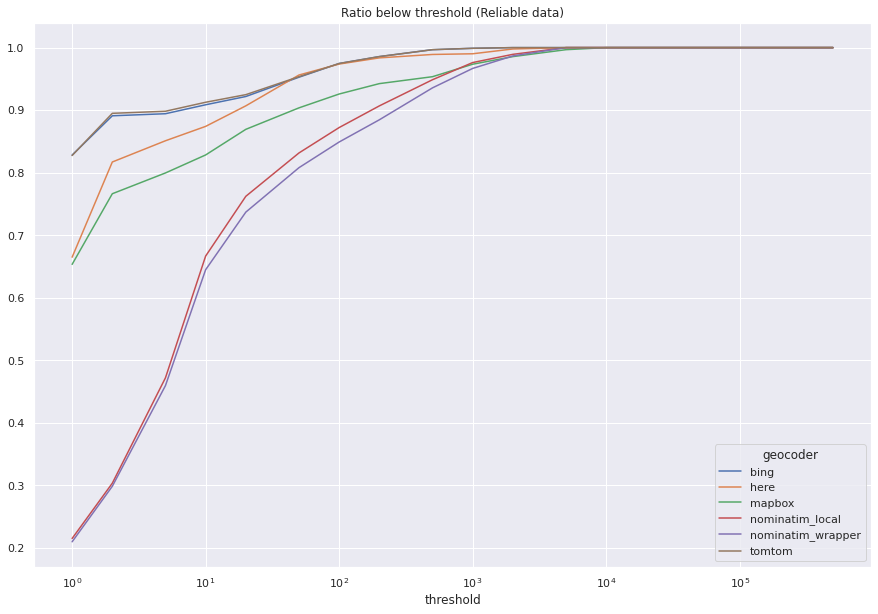

In [667]:
img_name=f"{fig_path}/dist2med_thresholds_reliable_{dataset}.png"

plot_threshold_ratio(geocoded_data[geocoded_data.is_reliable], "plt", title="Reliable data", filename=img_name)

pdf_add_image(pdf, img_name)

#

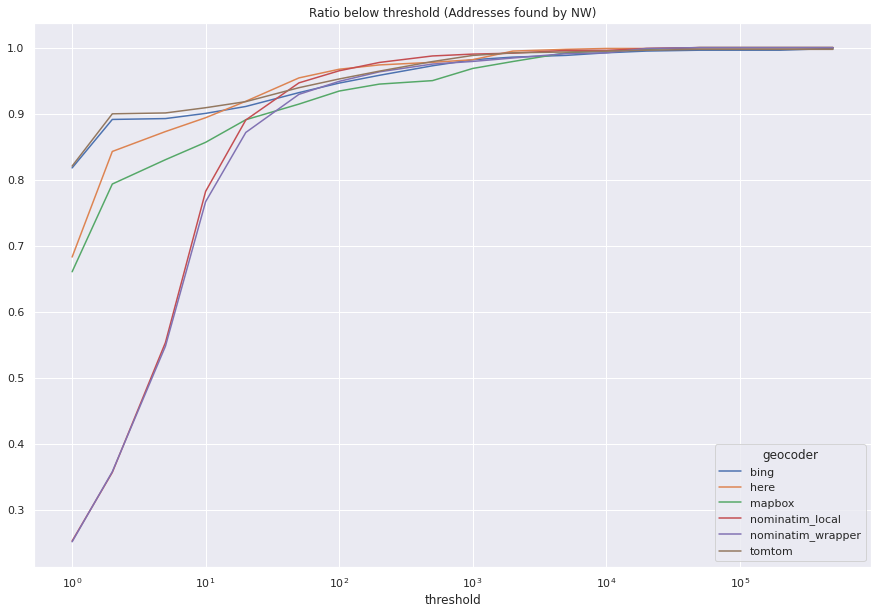

In [668]:
plot_threshold_ratio(geocoded_data[geocoded_data.address.isin(addresses_found_by_NW)], "plt", title="Addresses found by NW")

## Ratio far from median

In [ ]:
def get_far_from_threshold(geocoded_data, plotter="plt", filename=None):
    far_from_tresh = []
    for thresh in [10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)]:
        d = geocoded_data[geocoded_data.dist_to_median > thresh].geocoder.value_counts().rename("count_far_from_med").reset_index().rename({"index": "geocoder"}, axis=1)
        d["threshold"] = thresh
        far_from_tresh.append(d)
    far_from_tresh = pd.concat(far_from_tresh)#.set_index("index")
    df = far_from_tresh.set_index("threshold").pivot(columns="geocoder", values="count_far_from_med")
    if plotter=="plt":
        df.plot(logx=True, logy=True, figsize=(15,10), title="Number of results 'threshold' away from median")
        if filename:
             plt.savefig(filename, bbox_inches='tight')
    else:
        fig = px.line(df, y=geocoded_data.geocoder.unique(), title="Number of results 'threshold' away from median", log_x=True)
        fig.show()
    

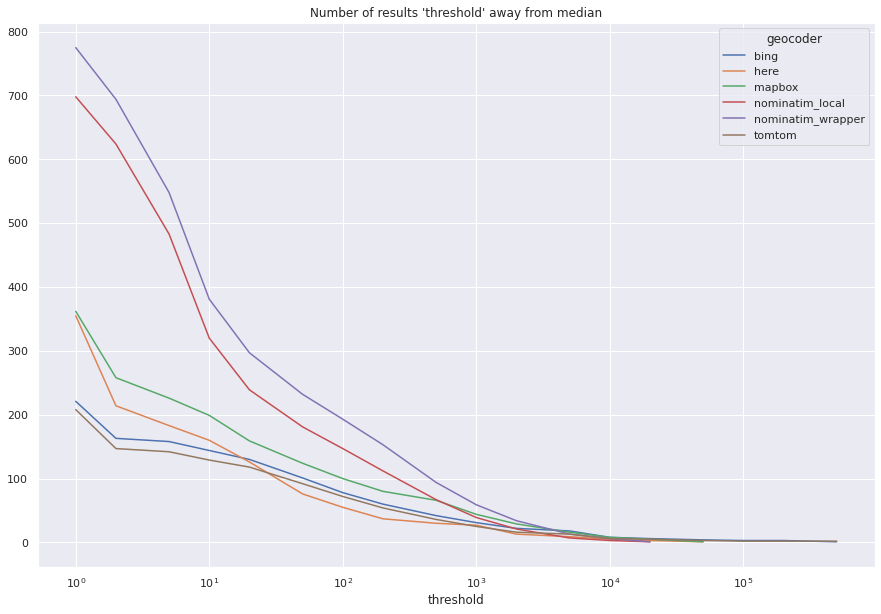

In [670]:
img_name=f"{fig_path}/far_from_thresholds_{dataset}.png"

get_far_from_threshold(geocoded_data, "plt", img_name)

pdf_add_image(pdf, img_name)


In [671]:
# get_far_from_threshold(geocoded_data[geocoded_data.precision=="building"])

## Correlations

In [672]:
points=geocoded_data[["address", "geocoder", "point"]].drop_duplicates().pivot(index="address", columns="geocoder", values="point")
points

geocoder                                                                      bing  \
address                                                                              
Aachener Strasse, 140, 4731 EYNATTEN, Belgique      POINT (677694.136 6569556.084)   
Aarschotsesteenweg, 6, 2230 HERSELT, Belgique       POINT (542981.967 6630252.704)   
Adolphe Demeurlaan, 41, 1060 SAINT-GILLES, Belg...  POINT (483663.150 6590470.448)   
Albert Meunierstraat, 110, 1160 AUDERGHEM, Belg...  POINT (493888.958 6587691.831)   
Amerikaansestraat, 119, 1050 IXELLES, Belgique      POINT (485362.999 6590003.462)   
...                                                                            ...   
rue du Centre, 200, 4950 WAIMES, Belgique           POINT (680299.012 6518466.145)   
rue du Collège, 1, 5310 EGHEZEE, Belgique           POINT (546412.834 6549538.066)   
rue du Trône, 65, 1050 IXELLES, Belgique            POINT (486280.271 6592715.875)   
rue du Vieux Frêne, 3, 4100 SERAING, Belgique       POINT (617962.323 6545011.692)   
rue francart, 11, 1050 IXELLES, Belgique            POINT (485763.749 6592380.961)   

geocoder                                                                      here  \
address                                                                              
Aachener Strasse, 140, 4731 EYNATTEN, Belgique      POINT (677694.136 6569556.084)   
Aarschotsesteenweg, 6, 2230 HERSELT, Belgique       POINT (542980.854 6630252.704)   
Adolphe Demeurlaan, 41, 1060 SAINT-GILLES, Belg...  POINT (483663.150 6590470.448)   
Albert Meunierstraat, 110, 1160 AUDERGHEM, Belg...  POINT (493888.958 6587691.831)   
Amerikaansestraat, 119, 1050 IXELLES, Belgique      POINT (485362.999 6590001.700)   
...                                                                            ...   
rue du Centre, 200, 4950 WAIMES, Belgique           POINT (680272.295 6518436.446)   
rue du Collège, 1, 5310 EGHEZEE, Belgique           POINT (546536.398 6549729.203)   
rue du Trône, 65, 1050 IXELLES, Belgique            POINT (486282.498 6592714.113)   
rue du Vieux Frêne, 3, 4100 SERAING, Belgique       POINT (613989.331 6552621.348)   
rue francart, 11, 1050 IXELLES, Belgique            POINT (485763.749 6592380.961)   

geocoder                                                                    mapbox  \
address                                                                              
Aachener Strasse, 140, 4731 EYNATTEN, Belgique      POINT (677694.358 6569555.733)   
Aarschotsesteenweg, 6, 2230 HERSELT, Belgique       POINT (542981.188 6630252.881)   
Adolphe Demeurlaan, 41, 1060 SAINT-GILLES, Belg...  POINT (483663.373 6590469.567)   
Albert Meunierstraat, 110, 1160 AUDERGHEM, Belg...  POINT (493889.404 6587691.302)   
Amerikaansestraat, 119, 1050 IXELLES, Belgique      POINT (486466.175 6591277.603)   
...                                                                            ...   
rue du Centre, 200, 4950 WAIMES, Belgique           POINT (680362.186 6518532.145)   
rue du Collège, 1, 5310 EGHEZEE, Belgique           POINT (546536.287 6549729.905)   
rue du Trône, 65, 1050 IXELLES, Belgique            POINT (486279.826 6592714.994)   
rue du Vieux Frêne, 3, 4100 SERAING, Belgique       POINT (618040.247 6545050.950)   
rue francart, 11, 1050 IXELLES, Belgique            POINT (485763.081 6592380.609)   

geocoder                                                           nominatim_local  \
address                                                                              
Aachener Strasse, 140, 4731 EYNATTEN, Belgique      POINT (677687.434 6569562.975)   
Aarschotsesteenweg, 6, 2230 HERSELT, Belgique       POINT (542975.049 6630256.104)   
Adolphe Demeurlaan, 41, 1060 SAINT-GILLES, Belg...  POINT (483662.826 6590467.267)   
Albert Meunierstraat, 110, 1160 AUDERGHEM, Belg...  POINT (493885.307 6587698.525)   
Amerikaansestraat, 119, 1050 IXELLES, Belgique      POINT (485901.351 6589764.499)   
...                                      

In [673]:
avg_dist = {}
for g1 in points:
    avg_dist[g1]={}
    for g2 in points:
        avg_dist[g1][g2]= gpd.GeoSeries(points[g1]).distance(gpd.GeoSeries(points[g2])).mean()
print("Average distance between points")

display(pd.DataFrame(avg_dist).style.background_gradient())


Average distance between points


In [674]:
# Skipping not reliable data

points=geocoded_data[geocoded_data.is_reliable][["address", "geocoder", "point"]].drop_duplicates().pivot(index="address", columns="geocoder", values="point")

avg_dist = {}
for g1 in points:
    avg_dist[g1]={}
    for g2 in points:
        avg_dist[g1][g2]= gpd.GeoSeries(points[g1]).distance(gpd.GeoSeries(points[g2])).mean()
print("Average distance between points")

display(pd.DataFrame(avg_dist).style.background_gradient())


Average distance between points


In [675]:
pdf.output(f"output/geocoding/report_{dataset}.pdf",'F')

''

# Comparing text results

In [676]:
geocoded_data

address  \
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique   
2     Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...   
3             rue du Centre, 200, 4950 WAIMES, Belgique   
4        Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique   
...                                                 ...   
5822         Rue Americaine, 90, 1050 IXELLES, Belgique   
5823          Kloosterstraat, 60, 2180 EKEREN, Belgique   
5824                    Markt, 13, 2490 BALEN, Belgique   
5825     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique   
5826        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique   

                                               location           geocoder  \
0     (198, Chaussée de Namur, Leuze, Éghezée, Namur...  nominatim_wrapper   
1     (Rue de la Halle, Namur, Wallonie, 5000, Belgi...  nominatim_wrapper   
2     (38, Avenue Jacques Sermon - Jacques Sermonlaa...  nominatim_wrapper   
3     (Rue du Centre, Waimes, Verviers, Liège, Wallo...  nominatim_wrapper   
4     (Tennisclub Lybo, 9, Kleine Waterstraat, Houtv...  nominatim_wrapper   
...                                                 ...                ...   
5822  (Rue Américaine 90, 1050 Bruxelles, (50.82335,...             tomtom   
5823  (Kloosterstraat 60, 2180 Antwerpen, (51.28145,...             tomtom   
5824        (Markt 13, 2490 Balen, (51.17048, 5.16843))             tomtom   
5825  (Lange Lobroekstraat 65, 2060 Antwerpen, (51.2...             tomtom   
5826    (Borgval 7, 1000 Bruxelles, (50.84764, 4.3484))             tomtom   

     precision                           point  is_in_belgium  \
0     building  POINT (546289.414 6543063.152)           True   
1       street  POINT (541625.695 6526810.311)           True   
2     building  POINT (481018.223 6598096.944)           True   
3       street  POINT (680379.741 6518655.149)           True   
4     building  POINT (535332.081 6628370.736)           True   
...        ...                             ...            ...   
5822  building  POINT (485258.358 6590105.668)           True   
5823  building  POINT (491767.209 6671230.785)           True   
5824  building  POINT (575346.996 6651505.244)           True   
5825  building  POINT (493394.700 6661940.684)           True   
5826  building  POINT (484061.674 6594387.125)           True   

                        median_point  dist_to_median  is_value_normal  \
0     POINT (546289.269 6543063.065)        0.168954             True   
1     POINT (541641.680 6526801.550)       18.228865             True   
2     POINT (481018.199 6598095.762)        1.182063             True   
3                               None             NaN            False   
4     POINT (535303.149 6628358.149)       31.551622             True   
...                              ...             ...              ...   
5822  POINT (485258.358 6590105.668)        0.000000             True   
5823  POINT (491767.209 6671230.785)        0.000000             True   
5824  POINT (575329.352 6651511.458)       18.706388             True   
5825  POINT (493394.700 6661940.684)        0.000000             True   
5826  POINT (484061.674 6594387.125)        0.000000             True   

      is_median_reliable  has_enough_matches  is_reliable  
0                   True                True         True  
1                   True                True         True  
2                   True                True         True  
3                  False                True        False  
4                   True                True         True  
...                  ...                 ...          ...  
5822                True                True         True  
5823                True                True         True  
5824                True                True         True  
5825                True                True         True  
5826                True                True         True  

[5827 rows x 12 columns

In [677]:
geocoded_data[geocoded_data.geocoder=="tomtom"].location.iloc[0].raw

{'type': 'Point Address',
 'id': 'BE/PAD/p0/3683617',
 'score': 13.9427499771,
 'address': {'streetNumber': '198',
  'streetName': 'Chaussée de Namur',
  'municipalitySubdivision': 'Leuze',
  'municipality': 'Eghezée',
  'countrySecondarySubdivision': 'Namur',
  'countryTertiarySubdivision': 'Namur',
  'countrySubdivision': 'Région Wallonne',
  'postalCode': '5310',
  'countryCode': 'BE',
  'country': 'Belgique',
  'countryCodeISO3': 'BEL',
  'freeformAddress': 'Chaussée de Namur 198, 5310 Eghezée',
  'localName': 'Eghezée'},
 'position': {'lat': 50.55563, 'lon': 4.9074},
 'viewport': {'topLeftPoint': {'lat': 50.55653, 'lon': 4.90598},
  'btmRightPoint': {'lat': 50.55473, 'lon': 4.90882}},
 'entryPoints': [{'type': 'main',
   'position': {'lat': 50.55561, 'lon': 4.90763}}]}

In [678]:
zipcode_field= {
    "nominatim_wrapper":"addr_out_postcode",
    "nominatim_wrapper2":"addr_out_postcode",
    "photon_local": ("properties", "postcode"),
    "here": ("Location", "Address", "PostalCode"),
    "bing": ("address", "postalCode"),
    "tomtom":("address", "postalCode")
               }
def get_zip(record):
    try: 
        field_list = zipcode_field[record.geocoder]
        
        if isinstance(field_list, str):
            field_list = [field_list]

        res=record.location.raw
        
        for f in field_list:
            res = res[f]
            #print(res)
            
        return res
    except KeyError: 
        return "[UNKNOWN]"
    

In [679]:
street_field= {
    "nominatim_wrapper": [["addr_out_street"]],
    "nominatim_wrapper2": [["addr_out_street"]],
    "photon_local": [["properties", "street"], 
                     ["properties", "name"]],
    "here": [["Location", "Address", "Street"]],
    "bing": [["address", "addressLine"]],
    "tomtom": [["address", "streetName"]]
               }
def get_street(record):
    field_list = street_field[record.geocoder]

    for attempt in field_list :
        res=record.location.raw
        try:
            for f in attempt:
                res = res[f]
            
            return res
        except KeyError: 
            pass
    return pd.NA#"[UNKNOWN]"
    

In [680]:
# textual_data.loc[5944].location.raw

In [681]:
textual_data = geocoded_data[~geocoded_data.geocoder.isin(["nominatim_local", "mapbox"])][["address", "geocoder", "location"]].copy()
textual_data

address           geocoder  \
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique  nominatim_wrapper   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique  nominatim_wrapper   
2     Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...  nominatim_wrapper   
3             rue du Centre, 200, 4950 WAIMES, Belgique  nominatim_wrapper   
4        Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique  nominatim_wrapper   
...                                                 ...                ...   
5822         Rue Americaine, 90, 1050 IXELLES, Belgique             tomtom   
5823          Kloosterstraat, 60, 2180 EKEREN, Belgique             tomtom   
5824                    Markt, 13, 2490 BALEN, Belgique             tomtom   
5825     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique             tomtom   
5826        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique             tomtom   

                                               location  
0     (198, Chaussée de Namur, Leuze, Éghezée, Namur...  
1     (Rue de la Halle, Namur, Wallonie, 5000, Belgi...  
2     (38, Avenue Jacques Sermon - Jacques Sermonlaa...  
3     (Rue du Centre, Waimes, Verviers, Liège, Wallo...  
4     (Tennisclub Lybo, 9, Kleine Waterstraat, Houtv...  
...                                                 ...  
5822  (Rue Américaine 90, 1050 Bruxelles, (50.82335,...  
5823  (Kloosterstraat 60, 2180 Antwerpen, (51.28145,...  
5824        (Markt 13, 2490 Balen, (51.17048, 5.16843))  
5825  (Lange Lobroekstraat 65, 2060 Antwerpen, (51.2...  
5826    (Borgval 7, 1000 Bruxelles, (50.84764, 4.3484))  

[3963 rows x 3 columns]

In [682]:
textual_data["zipcode"]=textual_data.apply(get_zip, axis=1)
textual_data

address           geocoder  \
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique  nominatim_wrapper   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique  nominatim_wrapper   
2     Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...  nominatim_wrapper   
3             rue du Centre, 200, 4950 WAIMES, Belgique  nominatim_wrapper   
4        Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique  nominatim_wrapper   
...                                                 ...                ...   
5822         Rue Americaine, 90, 1050 IXELLES, Belgique             tomtom   
5823          Kloosterstraat, 60, 2180 EKEREN, Belgique             tomtom   
5824                    Markt, 13, 2490 BALEN, Belgique             tomtom   
5825     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique             tomtom   
5826        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique             tomtom   

                                               location zipcode  
0     (198, Chaussée de Namur, Leuze, Éghezée, Namur...    5310  
1     (Rue de la Halle, Namur, Wallonie, 5000, Belgi...    5000  
2     (38, Avenue Jacques Sermon - Jacques Sermonlaa...    1083  
3     (Rue du Centre, Waimes, Verviers, Liège, Wallo...    4950  
4     (Tennisclub Lybo, 9, Kleine Waterstraat, Houtv...    2235  
...                                                 ...     ...  
5822  (Rue Américaine 90, 1050 Bruxelles, (50.82335,...    1050  
5823  (Kloosterstraat 60, 2180 Antwerpen, (51.28145,...    2180  
5824        (Markt 13, 2490 Balen, (51.17048, 5.16843))    2490  
5825  (Lange Lobroekstraat 65, 2060 Antwerpen, (51.2...    2060  
5826    (Borgval 7, 1000 Bruxelles, (50.84764, 4.3484))    1000  

[3963 rows x 4 columns]

In [683]:
textual_data[(textual_data.zipcode == "[UNKNOWN]") ]

address geocoder  \
3246  Rue de Danemark, 29, 1060 SAINT-GILLES, Belgique     bing   

                                               location    zipcode  
3246  (Denmark, (56.03480911254883, 9.319060325622559))  [UNKNOWN]

In [684]:
textual_data["street"]=textual_data.apply(get_street, axis=1).fillna("").replace("", pd.NA)
textual_data

address           geocoder  \
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique  nominatim_wrapper   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique  nominatim_wrapper   
2     Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...  nominatim_wrapper   
3             rue du Centre, 200, 4950 WAIMES, Belgique  nominatim_wrapper   
4        Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique  nominatim_wrapper   
...                                                 ...                ...   
5822         Rue Americaine, 90, 1050 IXELLES, Belgique             tomtom   
5823          Kloosterstraat, 60, 2180 EKEREN, Belgique             tomtom   
5824                    Markt, 13, 2490 BALEN, Belgique             tomtom   
5825     Lange Lobroekstraat, 65, 2060 ANVERS, Belgique             tomtom   
5826        Borgval, 7, 1000 BRUXELLES CENTRE, Belgique             tomtom   

                                               location zipcode  \
0     (198, Chaussée de Namur, Leuze, Éghezée, Namur...    5310   
1     (Rue de la Halle, Namur, Wallonie, 5000, Belgi...    5000   
2     (38, Avenue Jacques Sermon - Jacques Sermonlaa...    1083   
3     (Rue du Centre, Waimes, Verviers, Liège, Wallo...    4950   
4     (Tennisclub Lybo, 9, Kleine Waterstraat, Houtv...    2235   
...                                                 ...     ...   
5822  (Rue Américaine 90, 1050 Bruxelles, (50.82335,...    1050   
5823  (Kloosterstraat 60, 2180 Antwerpen, (51.28145,...    2180   
5824        (Markt 13, 2490 Balen, (51.17048, 5.16843))    2490   
5825  (Lange Lobroekstraat 65, 2060 Antwerpen, (51.2...    2060   
5826    (Borgval 7, 1000 Bruxelles, (50.84764, 4.3484))    1000   

                                          street  
0                              Chaussée de Namur  
1                                Rue de la Halle  
2     Avenue Jacques Sermon - Jacques Sermonlaan  
3                                  Rue du Centre  
4                             Kleine Waterstraat  
...                                          ...  
5822                              Rue Américaine  
5823                              Kloosterstraat  
5824                                       Markt  
5825                         Lange Lobroekstraat  
5826                                     Borgval  

[3963 rows x 5 columns]

In [685]:
textual_data[textual_data.street.isnull()]

address           geocoder  \
182       Nijverheidstraat, 13, 2260 WESTERLO, Belgique  nominatim_wrapper   
185          Place Verte, [na], 4800 VERVIERS, Belgique  nominatim_wrapper   
325            De Beaufays, 44, 4140 SPRIMONT, Belgique  nominatim_wrapper   
424   Midzele, 27, 2860 WAVRE-SAINTE-CATHERINE, Belg...  nominatim_wrapper   
464        Reginebeerplein, [na], 2018 ANVERS, Belgique  nominatim_wrapper   
515   Place vieille halle aux blés, 39, 1000 BRUXELL...  nominatim_wrapper   
896   Pont Saint Laurent, [na], 4800 VERVIERS, Belgique  nominatim_wrapper   
900   Plaine des Tilleuls, [na], 4600 RICHELLE, Belg...  nominatim_wrapper   
1940  PLACE EUGENE SIMONIS, 20, 1080 MOLENBEEK -SAIN...               here   
2017           Rue Defack, [na], 1050 IXELLES, Belgique               here   
2107      rue du Vieux Frêne, 3, 4100 SERAING, Belgique               here   
2296  Midzele, 27, 2860 WAVRE-SAINTE-CATHERINE, Belg...               here   
2533     Stationsstraat, 93, 2070 ZWIJNDRECHT, Belgique               here   
2756        De Vilegastraat, 13, 2600 BERCHEM, Belgique               here   
2781  Plaine des Tilleuls, [na], 4600 RICHELLE, Belg...               here   
2896  Steenweg op Antwerpen, 10, 2830 KLEIN WILLEBRO...               bing   
3246   Rue de Danemark, 29, 1060 SAINT-GILLES, Belgique               bing   
4878  Steenweg op Antwerpen, 10, 2830 KLEIN WILLEBRO...             tomtom   

                                               location    zipcode street  
182   (Klaverheidebos, Westerlo, Turnhout, Antwerpen...       2260   <NA>  
185   (Place Verte, Ensival, Verviers, Liège, Wallon...       4800   <NA>  
325   (À la Chaussée de Beaufays, Gomzé-Andoumont, S...       4140   <NA>  
424   (Sint-Katelijne-Waver, Mechelen, Antwerpen, Vl...       2860   <NA>  
464   (Antwerpen, Vlaanderen, 2018, België / Belgiqu...       2018   <NA>  
515   (Oud Korenhuis - Place de la Vieille Halle aux...       1000   <NA>  
896   (Pont, Malmedy, Verviers, Liège, Wallonie, 496...       4960   <NA>  
900   (Richelle, Visé, Liège, Wallonie, 4600, België...       4600   <NA>  
1940  (Molenbeek-Saint-Jean, Bruxelles, Belgique, Mo...       1080   <NA>  
2017  (Ixelles, Bruxelles, Belgique, Ixelles, Bruxel...       1050   <NA>  
2107  (Seraing, Wallonie, Belgique, Seraing, Walloni...       4100   <NA>  
2296  (Wavre, Wallonie, Belgique, Wavre, Wallonie 13...       1300   <NA>  
2533  (Zwijndrecht, Vlaanderen, België, Zwijndrecht,...       2070   <NA>  
2756  (Berchem, Antwerpen, Vlaanderen, België, Antwe...       2600   <NA>  
2781  (Richelle, Visé, Wallonie, Belgique, Visé, Wal...       4600   <NA>  
2896  (Kapelle-op-den-Bos, Flemish Region 2830, Belg...       2830   <NA>  
3246  (Denmark, (56.03480911254883, 9.319060325622559))  [UNKNOWN]   <NA>  
4878  (2830 Kapelle-op-den-Bos (Klein Willebroek), (...       2830   <NA>

In [686]:
# Bing does not split street & housenumber
textual_data.loc[textual_data.geocoder=="bing", "street"] =textual_data.loc[textual_data.geocoder=="bing"].street.str.extract("^(.+?)( [0-9]+[A-Z]?)?$")[0]

In [687]:
textual_data[textual_data.street.fillna("").str.contains("[0-9]")]

address           geocoder  \
10           Avenue Albert Ier, 14, 4600 VISE, Belgique  nominatim_wrapper   
203           Poederleeseweg, 111, 2275 LILLE, Belgique  nominatim_wrapper   
396          Parc de sept heures, 1, 4900 SPA, Belgique  nominatim_wrapper   
576   Chaussee de Louvain 566 | Champion, 566, 5000 ...  nominatim_wrapper   
679   Place du Roi Albert 1er, 4, 4300 WAREMME, Belg...  nominatim_wrapper   
768   route de Balmoral, 35, 4845 SART-LEZ-SPA, Belg...  nominatim_wrapper   
908   Place du roi Albert Premier, 3, 4300 WAREMME, ...  nominatim_wrapper   
1874         Avenue Albert Ier, 14, 4600 VISE, Belgique               here   
1913         Avenue Albert 1er, 12A, 4500 HUY, Belgique               here   
2268         Parc de sept heures, 1, 4900 SPA, Belgique               here   
2556  Place du Roi Albert 1er, 4, 4300 WAREMME, Belg...               here   
2622  Rue du Sourd d'Ave | situé au confins de la N9...               here   
2789  Place du roi Albert Premier, 3, 4300 WAREMME, ...               here   
2874         Avenue Albert Ier, 14, 4600 VISE, Belgique               bing   
2901  Château de Colonster, Allée des Erables, Bât B...               bing   
2913         Avenue Albert 1er, 12A, 4500 HUY, Belgique               bing   
2957  route des Jardins, 35, 5537 ANNEVOIE-ROUILLON,...               bing   
3052        Place du Stain, 1, 5140 SOMBREFFE, Belgique               bing   
3107      rue du Vieux Frêne, 3, 4100 SERAING, Belgique               bing   
3182  Rue de Fernelmont 1 bte 5, 1/5, 5020 CHAMPION,...               bing   
3293      Route de Givet, 224, 5570 BEAURAING, Belgique               bing   
3313        Route de Bastogne, 36, 4920 HARZE, Belgique               bing   
3370   Place Roi-Albert I, 12, 5580 ROCHEFORT, Belgique               bing   
3375    Place Albert 1er 29, 29, 4960 MALMEDY, Belgique               bing   
3391      Rue du Luxembourg, 35, 1050 IXELLES, Belgique               bing   
3400       Place Albert Ier, 19, 4960 MALMEDY, Belgique               bing   
3420       rue de Pascale, 20, 1040 ETTERBEEK, Belgique               bing   
3458   Route de Condroz, 38 C, 4100 BONCELLES, Belgique               bing   
3556  Place du Roi Albert 1er, 4, 4300 WAREMME, Belg...               bing   
3590  Rue du Luxembourg, 68, 1000 BRUXELLES CENTRE, ...               bing   
3648  route de Balmoral, 35, 4845 SART-LEZ-SPA, Belg...               bing   
3789  Place du roi Albert Premier, 3, 4300 WAREMME, ...               bing   
4857         Avenue Albert Ier, 14, 4600 VISE, Belgique             tomtom   
4883  Château de Colonster, Allée des Erables, Bât B...             tomtom   
4895         Avenue Albert 1er, 12A, 4500 HUY, Belgique             tomtom   
4938  route des Jardins, 35, 5537 ANNEVOIE-ROUILLON,...             tomtom   
5029        Place du Stain, 1, 5140 SOMBREFFE, Belgique             tomtom   
5084      rue du Vieux Frêne, 3, 4100 SERAING, Belgique             tomtom   
5265      Route de Givet, 224, 5570 BEAURAING, Belgique             tomtom   
5284        Route de Bastogne, 36, 4920 HARZE, Belgique             tomtom   
5341   Place Roi-Albert I, 12, 5580 ROCHEFORT, Belgique             tomtom   
5346    Place Albert 1er 29, 29, 4960 MALMEDY, Belgique             tomtom   
5371       Place Albert Ier, 19, 4960 MALMEDY, Belgique             tomtom   
5390       rue de Pascale, 20, 1040 ETTERBEEK, Belgique             tomtom   
5428   Route de Condroz, 38 C, 4100 BONCELLES, Belgique             tomtom   
5526  Place du Roi Albert 1er, 4, 4300 WAREMME, Belg...             tomtom   
5616  route de Balmoral, 35, 4845 SART-LEZ-SPA, Belg...             tomtom   
5753  Place du roi Albert Premier, 3, 4300 WAREMME, ...             tomtom   

                                               location zipcode  \
10    (Avenue Albert 1er, Visé, Liège, Wallonie, 460...    4600   
203   (11, Gierle, Lille, Turnhout, Antwerpen, Vlaan...    2275   
396   (La Tonnellerie, 1

In [688]:
textual_data.groupby("address").street.nunique().value_counts()

1    558
2    388
3     54
Name: street, dtype: int64

In [689]:
x = textual_data.groupby("address").street.nunique()
x[x>2].sort_values()

address
Adolphe Demeurlaan, 41, 1060 SAINT-GILLES, Belgique                      3
Place van Meenen, 33a, 1060 SAINT-GILLES, Belgique                       3
Predikherentraat, 8-10, 1000 BRUXELLES CENTRE, Belgique                  3
Quai aux Briques - Baksteenkaai, 60, 1000 BRUXELLES CENTRE, Belgique     3
Roodebeeksteenweg, 590, 1200 WOLUWE-SAINT-LAMBERT, Belgique              3
Route de Barisart, 295, 4900 SPA, Belgique                               3
Route de Maastricht, 100, 4651 BATTICE, Belgique                         3
Rue Alphonse de Witte, 40, 1050 IXELLES, Belgique                        3
Rue Edith Cavell, 92, 1180 UCCLE, Belgique                               3
Rue Franklin, 1, 1040 ETTERBEEK, Belgique                                3
Rue Godefroid Kurth, 85, 1140 EVERE, Belgique                            3
Rue Jaspar, 2, 4000 LIEGE, Belgique                                      3
Rue Jules Van Praet, 16, 1000 BRUXELLES CENTRE, Belgique                 3
Rue Jules Van Pra

In [690]:
textual_data[textual_data.address=="Gentse steenweg, 338, 9300 Aalst, Belgique"]

Empty DataFrame
Columns: [address, geocoder, location, zipcode, street]
Index: []

In [691]:
import jellyfish
def levenshtein_similarity(str1, str2):
    return 1-jellyfish.damerau_levenshtein_distance(str1, str2)/max(len(str1), len(str2)) if (len(str1) > 0 or len(str2) > 0  ) else 0.0

def get_weighed_distance(bloc):
    return bloc.apply(lambda x: (bloc.apply(lambda y: levenshtein_similarity(x, y)).mean()))
    
def get_agreement_count(bloc):
    bloc.apply(lambda x: print(x, "\n", bloc.apply(lambda y: levenshtein_similarity(x, y))))
    return bloc.apply(lambda x: (bloc.apply(lambda y: levenshtein_similarity(x, y)) > 0.9).sum())

In [692]:
textual_data[textual_data.address=="Kriekenlaan, 22, 2240 Zandhoven, Belgique"].fillna({"street": ""}).groupby("address").street.apply(get_weighed_distance)

Series([], Name: street, dtype: float64)

In [693]:
textual_data[textual_data.address=="Jozef Van Damstraat, 9B, 1932 Zaventem, Belgique"]

Empty DataFrame
Columns: [address, geocoder, location, zipcode, street]
Index: []

In [694]:
textual_data[textual_data.address=="Jozef Van Damstraat, 9B, 1932 Zaventem, Belgique"].fillna({"street": ""}).groupby("address").street.apply(get_agreement_count)

Series([], Name: street, dtype: float64)

In [695]:
textual_data["weighted_distance"] = textual_data.fillna({"street": ""}).groupby("address").street.apply(get_weighed_distance)

In [696]:
textual_data["agreement_count"] = textual_data.fillna({"street": ""}).groupby("address").street.apply(get_agreement_count)

Aachener Straße 
 961     1.000
2842    0.875
3842    1.000
5805    1.000
Name: Aachener Strasse, 140, 4731 EYNATTEN, Belgique, dtype: float64
Aachener Strasse 
 961     0.875
2842    1.000
3842    0.875
5805    0.875
Name: Aachener Strasse, 140, 4731 EYNATTEN, Belgique, dtype: float64
Aachener Straße 
 961     1.000
2842    0.875
3842    1.000
5805    1.000
Name: Aachener Strasse, 140, 4731 EYNATTEN, Belgique, dtype: float64
Aachener Straße 
 961     1.000
2842    0.875
3842    1.000
5805    1.000
Name: Aachener Strasse, 140, 4731 EYNATTEN, Belgique, dtype: float64
Aarschotsesteenweg 
 765     1.0
2645    1.0
3645    1.0
5613    1.0
Name: Aarschotsesteenweg, 6, 2230 HERSELT, Belgique, dtype: float64
Aarschotsesteenweg 
 765     1.0
2645    1.0
3645    1.0
5613    1.0
Name: Aarschotsesteenweg, 6, 2230 HERSELT, Belgique, dtype: float64
Aarschotsesteenweg 
 765     1.0
2645    1.0
3645    1.0
5613    1.0
Name: Aarschotsesteenweg, 6, 2230 HERSELT, Belgique, dtype: float64
Aarschotsesteenw

Avenue des Azalées 
 868     0.580645
2749    1.000000
3749    1.000000
5714    1.000000
Name: Avenue des azalées, 41, 1030 SCHAERBEEK, Belgique, dtype: float64
Avenue des Azalées 
 868     0.580645
2749    1.000000
3749    1.000000
5714    1.000000
Name: Avenue des azalées, 41, 1030 SCHAERBEEK, Belgique, dtype: float64
Avenue des Azalées 
 868     0.580645
2749    1.000000
3749    1.000000
5714    1.000000
Name: Avenue des azalées, 41, 1030 SCHAERBEEK, Belgique, dtype: float64
Avenue du Parc 
 332     1.0
2203    1.0
3203    1.0
5176    1.0
Name: Avenue du Parc, 32B, 4650 HERVE, Belgique, dtype: float64
Avenue du Parc 
 332     1.0
2203    1.0
3203    1.0
5176    1.0
Name: Avenue du Parc, 32B, 4650 HERVE, Belgique, dtype: float64
Avenue du Parc 
 332     1.0
2203    1.0
3203    1.0
5176    1.0
Name: Avenue du Parc, 32B, 4650 HERVE, Belgique, dtype: float64
Avenue du Parc 
 332     1.0
2203    1.0
3203    1.0
5176    1.0
Name: Avenue du Parc, 32B, 4650 HERVE, Belgique, dtype: float64
A

Chaussée de Dinant 
 248     1.0
2118    1.0
3118    1.0
5095    1.0
Name: Chaussée de Dinant 1080, 1080, 5100 WEPION, Belgique, dtype: float64
Chaussée de Dinant 
 248     1.0
2118    1.0
3118    1.0
5095    1.0
Name: Chaussée de Dinant 1080, 1080, 5100 WEPION, Belgique, dtype: float64
Chaussée de Dinant 
 835     1.0
2716    1.0
3716    1.0
5683    1.0
Name: Chaussée de Dinant, 126, 5100 WEPION, Belgique, dtype: float64
Chaussée de Dinant 
 835     1.0
2716    1.0
3716    1.0
5683    1.0
Name: Chaussée de Dinant, 126, 5100 WEPION, Belgique, dtype: float64
Chaussée de Dinant 
 835     1.0
2716    1.0
3716    1.0
5683    1.0
Name: Chaussée de Dinant, 126, 5100 WEPION, Belgique, dtype: float64
Chaussée de Dinant 
 835     1.0
2716    1.0
3716    1.0
5683    1.0
Name: Chaussée de Dinant, 126, 5100 WEPION, Belgique, dtype: float64
Chaussée de Dinant 
 323     1.0
2193    1.0
3193    1.0
5166    1.0
Name: Chaussée de Dinant, 1455, 5100 WEPION, Belgique, dtype: float64
Chaussée de Dinant 
 

 711     1.0
2589    1.0
3589    1.0
5558    1.0
Name: Eiermarkt, 46, 2000 ANVERS-CENTRE, Belgique, dtype: float64
Eiermarkt 
 711     1.0
2589    1.0
3589    1.0
5558    1.0
Name: Eiermarkt, 46, 2000 ANVERS-CENTRE, Belgique, dtype: float64
Ellermanstraat 
 216     1.0
2086    1.0
3086    1.0
5063    1.0
Name: Ellermanstraat, 96, 2060 ANVERS, Belgique, dtype: float64
Ellermanstraat 
 216     1.0
2086    1.0
3086    1.0
5063    1.0
Name: Ellermanstraat, 96, 2060 ANVERS, Belgique, dtype: float64
Ellermanstraat 
 216     1.0
2086    1.0
3086    1.0
5063    1.0
Name: Ellermanstraat, 96, 2060 ANVERS, Belgique, dtype: float64
Ellermanstraat 
 216     1.0
2086    1.0
3086    1.0
5063    1.0
Name: Ellermanstraat, 96, 2060 ANVERS, Belgique, dtype: float64
Emblemsesteenweg 
 793     1.0
2673    1.0
3673    1.0
5641    1.0
Name: Emblemsesteenweg, 73, 2560 KESSEL, Belgique, dtype: float64
Emblemsesteenweg 
 793     1.0
2673    1.0
3673    1.0
5641    1.0
Name: Emblemsesteenweg, 73, 2560 KESSEL, Be

Heilig Bloedlaan 
 568     1.0
2441    1.0
3441    1.0
5411    1.0
Name: Heilig Bloedlaan, 259, 2320 HOOGSTRATEN, Belgique, dtype: float64
Heistraat 
 322     1.0
2192    1.0
3192    1.0
5165    1.0
Name: Heistraat, 3, 2240 ZANDHOVEN, Belgique, dtype: float64
Heistraat 
 322     1.0
2192    1.0
3192    1.0
5165    1.0
Name: Heistraat, 3, 2240 ZANDHOVEN, Belgique, dtype: float64
Heistraat 
 322     1.0
2192    1.0
3192    1.0
5165    1.0
Name: Heistraat, 3, 2240 ZANDHOVEN, Belgique, dtype: float64
Heistraat 
 322     1.0
2192    1.0
3192    1.0
5165    1.0
Name: Heistraat, 3, 2240 ZANDHOVEN, Belgique, dtype: float64
Hendrik Conscienceplein 
 2688    1.0
3688    1.0
5655    1.0
Name: Hendrik Concienceplein, 9, 2000 ANVERS-CENTRE, Belgique, dtype: float64
Hendrik Conscienceplein 
 2688    1.0
3688    1.0
5655    1.0
Name: Hendrik Concienceplein, 9, 2000 ANVERS-CENTRE, Belgique, dtype: float64
Hendrik Conscienceplein 
 2688    1.0
3688    1.0
5655    1.0
Name: Hendrik Concienceplein, 9, 20

Kloosterstraat 
 101     1.0
1967    1.0
2967    1.0
4947    1.0
Name: Kloosterstraat, 11, 2400 MOL, Belgique, dtype: float64
Kloosterstraat 
 101     1.0
1967    1.0
2967    1.0
4947    1.0
Name: Kloosterstraat, 11, 2400 MOL, Belgique, dtype: float64
Kloosterstraat 
 101     1.0
1967    1.0
2967    1.0
4947    1.0
Name: Kloosterstraat, 11, 2400 MOL, Belgique, dtype: float64
Kloosterstraat 
 101     1.0
1967    1.0
2967    1.0
4947    1.0
Name: Kloosterstraat, 11, 2400 MOL, Belgique, dtype: float64
Kloosterstraat 
 290     1.0
2160    1.0
3160    1.0
5135    1.0
Name: Kloosterstraat, 155, 2000 ANVERS-CENTRE, Belgique, dtype: float64
Kloosterstraat 
 290     1.0
2160    1.0
3160    1.0
5135    1.0
Name: Kloosterstraat, 155, 2000 ANVERS-CENTRE, Belgique, dtype: float64
Kloosterstraat 
 290     1.0
2160    1.0
3160    1.0
5135    1.0
Name: Kloosterstraat, 155, 2000 ANVERS-CENTRE, Belgique, dtype: float64
Kloosterstraat 
 290     1.0
2160    1.0
3160    1.0
5135    1.0
Name: Kloosterstraat

Pelikaanstraat 
 904     1.0
2785    1.0
3785    1.0
5749    1.0
Name: Pelikaanstraat 3, 3, 2018 ANVERS, Belgique, dtype: float64
Pelikaanstraat 
 904     1.0
2785    1.0
3785    1.0
5749    1.0
Name: Pelikaanstraat 3, 3, 2018 ANVERS, Belgique, dtype: float64
Pertendonckstraat 
 613     1.0
2488    1.0
3488    1.0
5458    1.0
Name: Pertendonckstraat, 18, 2520 BROECHEM, Belgique, dtype: float64
Pertendonckstraat 
 613     1.0
2488    1.0
3488    1.0
5458    1.0
Name: Pertendonckstraat, 18, 2520 BROECHEM, Belgique, dtype: float64
Pertendonckstraat 
 613     1.0
2488    1.0
3488    1.0
5458    1.0
Name: Pertendonckstraat, 18, 2520 BROECHEM, Belgique, dtype: float64
Pertendonckstraat 
 613     1.0
2488    1.0
3488    1.0
5458    1.0
Name: Pertendonckstraat, 18, 2520 BROECHEM, Belgique, dtype: float64
Place Peter Benoit - Peter Benoitplein 
 920     1.000000
2801    0.447368
3801    0.447368
5765    0.447368
Name: Peter Benoit Plein, 1, 1120 NEDER-OVER-HEMBEEK, Belgique, dtype: float64
Pete

Name: Place du Roi Albert 1er, 4, 4300 WAREMME, Belgique, dtype: float64
Place du Roi Albert 1er 
 679     1.0
2556    1.0
3556    1.0
5526    1.0
Name: Place du Roi Albert 1er, 4, 4300 WAREMME, Belgique, dtype: float64
Place du Roi Albert 1er 
 679     1.0
2556    1.0
3556    1.0
5526    1.0
Name: Place du Roi Albert 1er, 4, 4300 WAREMME, Belgique, dtype: float64
Place du Stain 
 183     1.000000
2052    0.500000
3052    0.318182
5029    0.318182
Name: Place du Stain, 1, 5140 SOMBREFFE, Belgique, dtype: float64
Rue Stain 
 183     0.500000
2052    1.000000
3052    0.227273
5029    0.227273
Name: Place du Stain, 1, 5140 SOMBREFFE, Belgique, dtype: float64
Avenue du 16 Juin 1815 
 183     0.318182
2052    0.227273
3052    1.000000
5029    1.000000
Name: Place du Stain, 1, 5140 SOMBREFFE, Belgique, dtype: float64
Avenue du 16 Juin 1815 
 183     0.318182
2052    0.227273
3052    1.000000
5029    1.000000
Name: Place du Stain, 1, 5140 SOMBREFFE, Belgique, dtype: float64
Place du Théâtre 


Rue Dejoncker - Dejonckerstraat 
 622     1.000000
2497    0.419355
3497    0.419355
5467    0.419355
Name: Rue Dejoncker, 25, 1060 SAINT-GILLES, Belgique, dtype: float64
Rue Dejoncker 
 622     0.419355
2497    1.000000
3497    1.000000
5467    1.000000
Name: Rue Dejoncker, 25, 1060 SAINT-GILLES, Belgique, dtype: float64
Rue Dejoncker 
 622     0.419355
2497    1.000000
3497    1.000000
5467    1.000000
Name: Rue Dejoncker, 25, 1060 SAINT-GILLES, Belgique, dtype: float64
Rue Dejoncker 
 622     0.419355
2497    1.000000
3497    1.000000
5467    1.000000
Name: Rue Dejoncker, 25, 1060 SAINT-GILLES, Belgique, dtype: float64
Rue Devant l'Etang 
 943     1.0
2824    1.0
3824    1.0
5787    1.0
Name: Rue Devant L'Etang, 11, 4960 MALMEDY, Belgique, dtype: float64
Rue Devant l'Etang 
 943     1.0
2824    1.0
3824    1.0
5787    1.0
Name: Rue Devant L'Etang, 11, 4960 MALMEDY, Belgique, dtype: float64
Rue Devant l'Etang 
 943     1.0
2824    1.0
3824    1.0
5787    1.0
Name: Rue Devant L'Etang,

Rue Saint-Boniface 
 48      0.45
1914    1.00
2914    1.00
4896    1.00
Name: Rue Saint-Boniface, 35, 1050 IXELLES, Belgique, dtype: float64
Rue Saint-Gilles 
 43      1.0
1908    1.0
2908    1.0
4890    1.0
Name: Rue Saint-Gilles, 180, 4000 LIEGE, Belgique, dtype: float64
Rue Saint-Gilles 
 43      1.0
1908    1.0
2908    1.0
4890    1.0
Name: Rue Saint-Gilles, 180, 4000 LIEGE, Belgique, dtype: float64
Rue Saint-Gilles 
 43      1.0
1908    1.0
2908    1.0
4890    1.0
Name: Rue Saint-Gilles, 180, 4000 LIEGE, Belgique, dtype: float64
Rue Saint-Gilles 
 43      1.0
1908    1.0
2908    1.0
4890    1.0
Name: Rue Saint-Gilles, 180, 4000 LIEGE, Belgique, dtype: float64
Rue Saint-Gilles 
 644     1.0
2519    1.0
3519    1.0
5489    1.0
Name: Rue Saint-Gilles, 2, 4000 LIEGE, Belgique, dtype: float64
Rue Saint-Gilles 
 644     1.0
2519    1.0
3519    1.0
5489    1.0
Name: Rue Saint-Gilles, 2, 4000 LIEGE, Belgique, dtype: float64
Rue Saint-Gilles 
 644     1.0
2519    1.0
3519    1.0
5489    1

 432     0.823529
2304    1.000000
3304    0.823529
5276    0.823529
Name: Rue de Bironfosse 38, 38, 5630 CERFONTAINE, Belgique, dtype: float64
Rue de Bironfosse 
 432     1.000000
2304    0.823529
3304    1.000000
5276    1.000000
Name: Rue de Bironfosse 38, 38, 5630 CERFONTAINE, Belgique, dtype: float64
Rue de Bironfosse 
 432     1.000000
2304    0.823529
3304    1.000000
5276    1.000000
Name: Rue de Bironfosse 38, 38, 5630 CERFONTAINE, Belgique, dtype: float64
Rue de Bouillon 
 867     1.0
2748    1.0
3748    1.0
5713    1.0
Name: Rue de Bouillon, 25, 5570 BEAURAING, Belgique, dtype: float64
Rue de Bouillon 
 867     1.0
2748    1.0
3748    1.0
5713    1.0
Name: Rue de Bouillon, 25, 5570 BEAURAING, Belgique, dtype: float64
Rue de Bouillon 
 867     1.0
2748    1.0
3748    1.0
5713    1.0
Name: Rue de Bouillon, 25, 5570 BEAURAING, Belgique, dtype: float64
Rue de Bouillon 
 867     1.0
2748    1.0
3748    1.0
5713    1.0
Name: Rue de Bouillon, 25, 5570 BEAURAING, Belgique, dtype: fl

 25      0.5
1889    1.0
2889    1.0
4871    1.0
Name: Rue de la Paix, 26, 1050 IXELLES, Belgique, dtype: float64
Rue de la Paix - Vredestraat 
 199     1.0
2068    0.5
3068    0.5
5045    0.5
Name: Rue de la Paix, 51, 1050 IXELLES, Belgique, dtype: float64
Rue de la Paix 
 199     0.5
2068    1.0
3068    1.0
5045    1.0
Name: Rue de la Paix, 51, 1050 IXELLES, Belgique, dtype: float64
Rue de la Paix 
 199     0.5
2068    1.0
3068    1.0
5045    1.0
Name: Rue de la Paix, 51, 1050 IXELLES, Belgique, dtype: float64
Rue de la Paix 
 199     0.5
2068    1.0
3068    1.0
5045    1.0
Name: Rue de la Paix, 51, 1050 IXELLES, Belgique, dtype: float64
Rue de la Place 
 163     1.0
2031    1.0
3031    1.0
5009    1.0
Name: Rue de la Place, 1, 5030 GEMBLOUX, Belgique, dtype: float64
Rue de la Place 
 163     1.0
2031    1.0
3031    1.0
5009    1.0
Name: Rue de la Place, 1, 5030 GEMBLOUX, Belgique, dtype: float64
Rue de la Place 
 163     1.0
2031    1.0
3031    1.0
5009    1.0
Name: Rue de la Place,

Rue du Page 
 638     0.37931
2513    1.00000
3513    1.00000
5483    1.00000
Name: Rue du Page, 31, 1050 IXELLES, Belgique, dtype: float64
Rue du Page 
 638     0.37931
2513    1.00000
3513    1.00000
5483    1.00000
Name: Rue du Page, 31, 1050 IXELLES, Belgique, dtype: float64
Rue du Page 
 638     0.37931
2513    1.00000
3513    1.00000
5483    1.00000
Name: Rue du Page, 31, 1050 IXELLES, Belgique, dtype: float64
Rue du Plan Incliné 
 796     1.0
2676    1.0
3676    1.0
5644    1.0
Name: Rue du Plan Incliné, 115, 4000 LIEGE, Belgique, dtype: float64
Rue du Plan Incliné 
 796     1.0
2676    1.0
3676    1.0
5644    1.0
Name: Rue du Plan Incliné, 115, 4000 LIEGE, Belgique, dtype: float64
Rue du Plan Incliné 
 796     1.0
2676    1.0
3676    1.0
5644    1.0
Name: Rue du Plan Incliné, 115, 4000 LIEGE, Belgique, dtype: float64
Rue du Plan Incliné 
 796     1.0
2676    1.0
3676    1.0
5644    1.0
Name: Rue du Plan Incliné, 115, 4000 LIEGE, Belgique, dtype: float64
Rue du Pont de la Carpe 

Name: Square Georges Marlow, 37, 1180 UCCLE, Belgique, dtype: float64
Square Georges Marlow 
 949     0.477273
2830    1.000000
3830    1.000000
5793    1.000000
Name: Square Georges Marlow, 37, 1180 UCCLE, Belgique, dtype: float64
Square Georges Marlow 
 949     0.477273
2830    1.000000
3830    1.000000
5793    1.000000
Name: Square Georges Marlow, 37, 1180 UCCLE, Belgique, dtype: float64
Square Levie - Levieplein 
 302     1.00
2172    0.48
3172    0.48
5146    0.48
Name: Square Levie, 1, 1200 WOLUWE-SAINT-LAMBERT, Belgique, dtype: float64
Square Levie 
 302     0.48
2172    1.00
3172    1.00
5146    1.00
Name: Square Levie, 1, 1200 WOLUWE-SAINT-LAMBERT, Belgique, dtype: float64
Square Levie 
 302     0.48
2172    1.00
3172    1.00
5146    1.00
Name: Square Levie, 1, 1200 WOLUWE-SAINT-LAMBERT, Belgique, dtype: float64
Square Levie 
 302     0.48
2172    1.00
3172    1.00
5146    1.00
Name: Square Levie, 1, 1200 WOLUWE-SAINT-LAMBERT, Belgique, dtype: float64
Avenue de Stalingrad - St

Vorselaarsebaan 
 693     1.0
2571    1.0
3571    1.0
5540    1.0
Name: Vorselaarsebaan, 60, 2200 HERENTALS, Belgique, dtype: float64
Vorselaarsebaan 
 693     1.0
2571    1.0
3571    1.0
5540    1.0
Name: Vorselaarsebaan, 60, 2200 HERENTALS, Belgique, dtype: float64
Vorselaarsebaan 
 693     1.0
2571    1.0
3571    1.0
5540    1.0
Name: Vorselaarsebaan, 60, 2200 HERENTALS, Belgique, dtype: float64
Vorselaarsebaan 
 693     1.0
2571    1.0
3571    1.0
5540    1.0
Name: Vorselaarsebaan, 60, 2200 HERENTALS, Belgique, dtype: float64
Vosstraat 
 851     1.0
2732    1.0
3732    1.0
5698    1.0
Name: Vosstraat, 4, 2140 BORGERHOUT, Belgique, dtype: float64
Vosstraat 
 851     1.0
2732    1.0
3732    1.0
5698    1.0
Name: Vosstraat, 4, 2140 BORGERHOUT, Belgique, dtype: float64
Vosstraat 
 851     1.0
2732    1.0
3732    1.0
5698    1.0
Name: Vosstraat, 4, 2140 BORGERHOUT, Belgique, dtype: float64
Vosstraat 
 851     1.0
2732    1.0
3732    1.0
5698    1.0
Name: Vosstraat, 4, 2140 BORGERHOUT, B

Rue du Collège 
 415     1.0
2287    1.0
3287    1.0
5259    1.0
Name: rue du Collège, 1, 5310 EGHEZEE, Belgique, dtype: float64
Rue du Collège 
 415     1.0
2287    1.0
3287    1.0
5259    1.0
Name: rue du Collège, 1, 5310 EGHEZEE, Belgique, dtype: float64
Rue du Collège 
 415     1.0
2287    1.0
3287    1.0
5259    1.0
Name: rue du Collège, 1, 5310 EGHEZEE, Belgique, dtype: float64
Rue du Collège 
 415     1.0
2287    1.0
3287    1.0
5259    1.0
Name: rue du Collège, 1, 5310 EGHEZEE, Belgique, dtype: float64
Rue du Trône - Troonstraat 
 922     1.000000
2803    0.461538
3803    0.461538
5767    0.461538
Name: rue du Trône, 65, 1050 IXELLES, Belgique, dtype: float64
Rue du Trône 
 922     0.461538
2803    1.000000
3803    1.000000
5767    1.000000
Name: rue du Trône, 65, 1050 IXELLES, Belgique, dtype: float64
Rue du Trône 
 922     0.461538
2803    1.000000
3803    1.000000
5767    1.000000
Name: rue du Trône, 65, 1050 IXELLES, Belgique, dtype: float64
Rue du Trône 
 922     0.461538


geocoder
bing                 0.930920
here                 0.921390
nominatim_wrapper    0.838015
tomtom               0.933602
Name: weighted_distance, dtype: float64

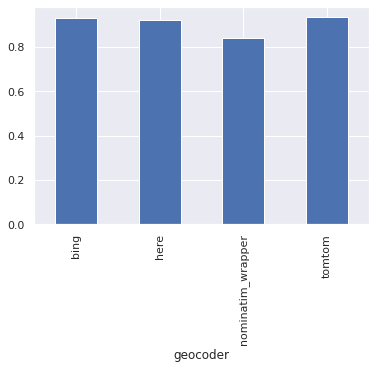

In [697]:
d = textual_data.groupby("geocoder").weighted_distance.mean()
d.plot.bar()
d

geocoder
bing                 3.468000
here                 3.400000
nominatim_wrapper    2.798576
tomtom               3.495918
Name: agreement_count, dtype: float64

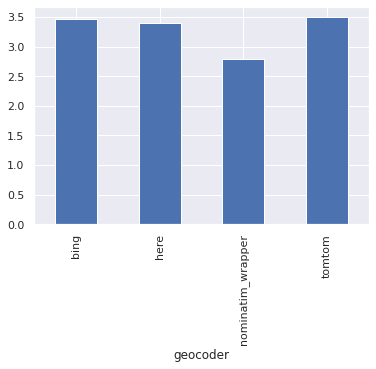

In [698]:
d = textual_data.groupby("geocoder").agreement_count.mean()
d.plot.bar()
d

In [699]:
textual_data.groupby("address").weighted_distance.mean().sort_values()

address
Steenweg op Antwerpen, 10, 2830 KLEIN WILLEBROEK, Belgique    0.111111
Plaine des Tilleuls, [na], 4600 RICHELLE, Belgique            0.250000
Midzele, 27, 2860 WAVRE-SAINTE-CATHERINE, Belgique            0.250000
Rue Defack, [na], 1050 IXELLES, Belgique                      0.349537
rue du Vieux Frêne, 3, 4100 SERAING, Belgique                 0.412500
                                                                ...   
Hockeystraat, 20, 2020 ANVERS, Belgique                       1.000000
Hessenbrug, 6, 2000 ANVERS-CENTRE, Belgique                   1.000000
Rue Hazinelle, 4, 4000 LIEGE, Belgique                        1.000000
Hondstraat, 11, 2440 GEEL, Belgique                           1.000000
Place du Théatre, 13, 5000 NAMUR, Belgique                    1.000000
Name: weighted_distance, Length: 1000, dtype: float64

In [700]:
x = textual_data.groupby("address").agreement_count.mean().sort_values()
x[x<5]

address
Steenweg op Antwerpen, 10, 2830 KLEIN WILLEBROEK, Belgique               0.333333
Plaine des Tilleuls, [na], 4600 RICHELLE, Belgique                       1.000000
Siberiastraat Z/N (voormalig droogdok 7), [na], 2030 ANVERS, Belgique    1.000000
Sint-Nikolaasgang, 8/4, 1000 BRUXELLES CENTRE, Belgique                  1.000000
Midzele, 27, 2860 WAVRE-SAINTE-CATHERINE, Belgique                       1.000000
                                                                           ...   
Route d'Inzemont, 1, 5540 HASTIERE, Belgique                             4.000000
Route d'achêne, 1, 5561 CELLES, Belgique                                 4.000000
De Keyserlei, 47, 2018 ANVERS, Belgique                                  4.000000
Corbeillestraat, 40, 2235 WESTMEERBEEK, Belgique                         4.000000
Place du Théatre, 13, 5000 NAMUR, Belgique                               4.000000
Name: agreement_count, Length: 1000, dtype: float64

In [701]:
textual_data[textual_data.address=="Eerstestraat(STL), 16, 9980 Sint-Laureins, Belgique"]

Empty DataFrame
Columns: [address, geocoder, location, zipcode, street, weighted_distance, agreement_count]
Index: []

<AxesSubplot:xlabel='geocoder'>

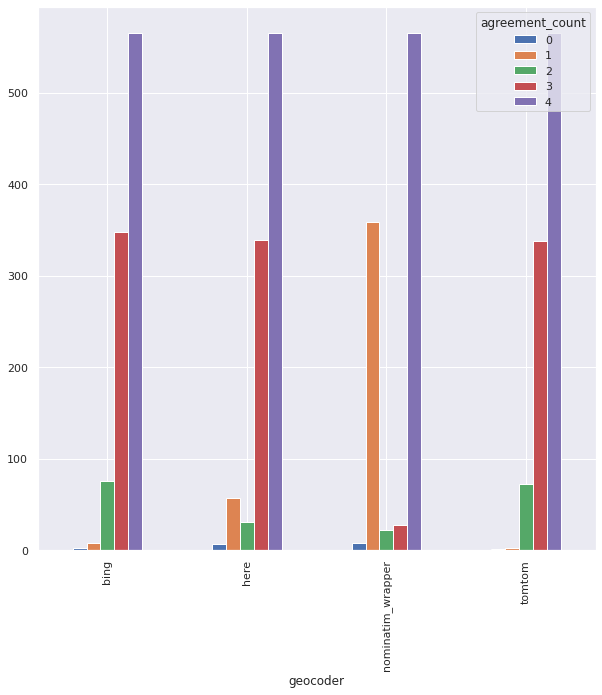

In [702]:
d = textual_data.groupby("geocoder").agreement_count.value_counts()
d.unstack().plot.bar(figsize=(10,10))